In [1]:
import numpy as np
from pc_kriging import PC_Kriging
import matplotlib.pyplot as plt
from scipy.stats import norm
from doepy import build
from scipy import optimize
import pandas as pd
from numpy import genfromtxt
import pickle

from scipy.special import eval_legendre, eval_hermitenorm
import scipy.special

# adaptive learning - expected feasiability function --------------------------------------------------------------

def EFF(u,v,z):
    zl=-2*v
    zh=2*v
    return ((u-z)*( 2*norm.cdf((z-u)/v) - norm.cdf((zl-u)/v) - norm.cdf((zh-u)/v)) 
           -(v)*( 2*norm.pdf((z-u)/v) - norm.pdf((zl-u)/v) - norm.pdf((zh-u)/v))  
           +(2*v)*(norm.cdf((zh-u)/v) - norm.cdf((zl-u)/v)))

def U_function(u, v):
    return np.abs(u)/v

def LinearNorm(x,oldmin,oldmax,newmin,newmax):    # scaling linearly X to new domain limits
    return newmin + ((x-oldmin)*(newmax-newmin)/(oldmax-oldmin))


def VoronoiCell(x,xn):   #given x [single value] return the index of the closest xn [array]
    dist=PCK1.distance(x.reshape(1,-1),xn)
    return np.argmin(dist)

# Limit State 1

In [2]:
# #ground truth function 1 ----------------------------------------------------
# https://rprepo.readthedocs.io/en/latest/reliability_problems.html#rp201

def gfun_53(x):
    """Performance function for reliability problem 53.

    Parameters
    ----------
        x : numpy.array of float(s)
            Values of independent variables: columns are the different parameters/random variables (x1, x2,...xn) and rows are different parameter/random variables sets for different calls.

    Returns
    -------
        g_val_sys : numpy.array of float(s)
            Performance function value for the system.
        g_val_comp : numpy.array of float(s)
            Performance function value for each component.
        msg : str
            Accompanying diagnostic message, e.g. warning.
    """
#     import numpy as np
    # expected number of random variables/columns
    nrv_e = 2

    g = float('nan')
    msg = 'Ok'
    x = np.array(x, dtype='f')

    n_dim = len(x.shape)
    if n_dim == 1:
        x = np.array(x)[np.newaxis]
    elif n_dim > 2:
        msg = 'Only available for 1D and 2D arrays.'
        return float('nan'), float('nan'), msg

    nrv_p = x.shape[1]
    if nrv_p != nrv_e:
        msg = f'The number of random variables (x, columns) is expected to be {nrv_e} but {nrv_p} is provided!'
    else:
        g = np.sin(5*x[:, 0]/2) + 2 - (x[:, 0]**2 + 4)*(x[:, 1] - 1)/20

    g_val_sys = g
    g_val_comp = g
    return g_val_sys, g_val_comp, msg

# Limit State 2

In [3]:
# ground truth function 2 ----------------------------------------------------
# https://rprepo.readthedocs.io/en/latest/reliability_problems.html#rp201

def LState2(x):
    #"""Modified Performance function for reliability problem 53""""
  
    # expected number of random variables/columns
    nrv_e = 2

    g = float('nan')
    msg = 'Ok'
    x = np.array(x, dtype='f')

    n_dim = len(x.shape)
    if n_dim == 1:
        x = np.array(x)[np.newaxis]
    elif n_dim > 2:
        msg = 'Only available for 1D and 2D arrays.'
        return float('nan'), float('nan'), msg

    nrv_p = x.shape[1]
    if nrv_p != nrv_e:
        msg = f'The number of random variables (x, columns) is expected to be {nrv_e} but {nrv_p} is provided!'
    else:
        #new limit state -----------------------------------------------------
        g = np.sin(2.0*x[:, 0]) -0.5 - (x[:, 0]**2 + 4)*(-1.0*x[:, 1] - 1)/20
        
    g_val_sys = g
    g_val_comp = g
    return g_val_sys, g_val_comp, msg

In [4]:
config = {"pol_type": ['hermite', 'hermite']}   #design variables following normal distribution
PCK1 = PC_Kriging(config)
PCK_loo = PC_Kriging(config)    # for LOOCV with same 'config' as specified in the original model

In [5]:
# objective function to optimize length scale --------------------------------------------------------
def L_Object (l):
    v = 5/2
    N = len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)
    
    modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
    ### ------------------Theta_ by UQLab User Manual PCK(C. Lataniotis, D. Wicaksono, S. Marelli, B. Sudret)------------------------------
    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = PCK1.InfoMat @ modelpar2[0]
    ins = (yn-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))

## Loading initial parameters and generating test points

In [6]:
function_1 = gfun_53   #ground truth function 1 
function_2 = LState2   #ground truth function 2

dim = 2       # dimensionality

x1mean, x1sigma = 1.5 , 1.0  # normal distribution 
x2mean, x2sigma = 2.5 , 1.0  # normal distribution 

ntest = 5000  # test points

# TEST POINTS -------------------------------------------------
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
YN_1 = np.zeros(int(ntest))
YN_2 = np.zeros(int(ntest))
#variable 1 ---------------------------------------------------
XN[:,0] = np.random.normal(0,1,ntest)  
XR[:,0] = PCK1.scalehermite(XN[:,0], x1mean, x1sigma)  
#variable 2 ---------------------------------------------------
XN[:,1] = np.random.normal(0,1,ntest)  
XR[:,1] = PCK1.scalehermite(XN[:,1], x2mean, x2sigma)  

YN_1 = function_1(XR)[0]
YN_2 = function_2(XR)[0]

In [144]:
fail_samples_1 = np.sum(YN_1 < 0 )
Pf_ref_1 = fail_samples_1/ntest

fail_samples_2 = np.sum(YN_2 < 0 )
Pf_ref_2 = fail_samples_2/ntest

Pf_ref_1, Pf_ref_2

(0.036, 0.1424)

<IPython.core.display.Javascript object>


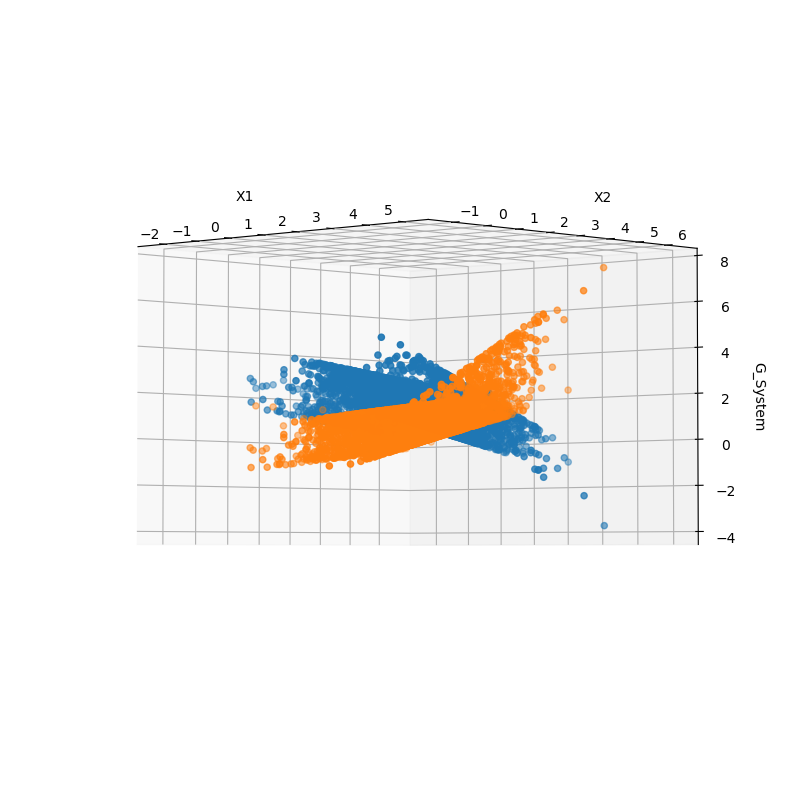

Text(0.5, 0, 'G_System')

In [136]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XR[:,0],XR[:,1], YN_1)
ax.scatter(XR[:,0],XR[:,1], YN_2)             #plotting the last trained surrogate
# ax.scatter(xr[:,0],xr[:,1], yn, color='red')   #observation points 
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('G_System')

# Active training - U - 2 LS

In [148]:
number_experiments = 15
number_active_points = 40

training_limitstate = 1

results_file = '_AT1_U_' + str(number_active_points)   # index for results files

for experiments in range(number_experiments):
    print('Experiment: ', experiments+1 , '#################################################################' )
    
    ActiveTrain_1 = {}   #results file { Surrogate , Pf, CoV_Pf , eLoo , mse }
    ActiveTrain_2 = {}   #results file { Surrogate , Pf, CoV_Pf , eLoo , mse }

    #INITIAL design of experiments (LHS) passive training ####################################

    n = 10       # number of initial sampling

    xn = np.zeros((int(n), dim))      #normalized training points
    xr = np.zeros((int(n), dim))      #scaled training points
    yn = np.zeros((int(n)))           #observations

    # Check the variables limits for space-filling distribution
    Xdoe = build.space_filling_lhs( {'x1':[-1, 1],      
                                     'x2':[-1, 1],} , 
                                      num_samples = n )
    #------------------------------------------------------------
    xn[:,0] = Xdoe['x1']
    xn[:,1] = Xdoe['x2']
    xr[:,0] = PCK1.scalehermite(xn[:,0], x1mean, x1sigma)
    xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma)

    yn_1 = function_1(xr)[0]
    yn_2 = function_2(xr)[0]
    
    # kernel hyperparameters-------------------------------------
    v = 5/2        #Gaussian process
    #truncation term-------------------------------------
    p_max = 5  #for each variable → same truncation , degree of expansion
    
    for points in range(number_active_points):

        # Selecting the smallest e_loo model (length and order)
        
        mse_results = np.zeros(p_max-1)
        opt_length_it = np.zeros(p_max-1)
        eloo_results = np.zeros(p_max-1)

        mean_loo = np.zeros(len(xn))
        var_loo = np.zeros(len(xn))

        dist = PCK1.distance(xr, xr)
        lmax = np.max(dist)
        lmin = np.min(dist[dist!=0])
        bounds = [(lmin, lmax)]

        results = dict()
        
        # ##############################################################################
        # Active training of Limit State 1 #############################################

        ModelName_1 = 'PCK1_' + str(len(xn))
        
        ModelName_1 = PC_Kriging(config)

        # yn is changing for each LS (inside L_Object )
        yn = yn_1    #observations
        YN = YN_1    #test points

        # OPTIMAL SURROGATE MODEL -----------------------------------
        for p in range(1, p_max):

            results['shgo'] = optimize.shgo(L_Object, bounds)
            opt_length = results['shgo']['x'][0]

            theta = np.array([opt_length, v])

            #Generating PCK models for each reduced design of experiments 

            for i in range (0, len(xn) ):

                yn_loo= np.delete(yn,[i])                            #y_n-i      leaving element i out the observations 
                xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)    #x1r_n-i   leaving element i out the inputs (xr)
                xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)    #x_n-i     leaving element i out the nomalized inputs (xn)

                #training LOO
                modelpar_loo = PCK_loo.train (xn_loo , yn_loo , p , theta )

                #predicting LOO over each removed sample
                mean_loo[i], var_loo[i] = PCK_loo.predict_fast(xn[i].reshape(1,-1))

            e_loo = np.mean (yn - mean_loo)**2              #LOO CV squared errors

            eloo_results[p-1] = e_loo

            #--------------------------------------- error over a set of test points
            modelpar1 = ModelName_1.train (xn, yn, p, theta) 
            mean0, var0 = ModelName_1.predict_fast(XN)    # test points predictions mean, variance

            mse = np.mean ((YN - mean0)**2)

            mse_results[p-1] = mse
            opt_length_it[p-1] = opt_length

    #         print('Degree', p, 'MSE', "%.2f" % round(mse, 2) , 'e_LOO', "%.5f" % e_loo)

        ## training optimal model ----------------------------

        opt = np.argmin(eloo_results)    #selected based 'eloo' instead 'mse'
        theta_opt = np.array([opt_length_it[opt], v]) 

        modelpar1 = ModelName_1.train (xn, yn, int(opt+1), theta_opt) 

        ## Pool of samples for MCS -----------------------------------
        MCS_samples = 100000

        MCinputs_norm = np.zeros((int(MCS_samples), dim))
        MCinputs = np.zeros((int(MCS_samples), dim))

        MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
        MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

        MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
        MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  
    
        # Pf estimation ----------------------------------------------
        
            # ground truth ls
        ymc_1 = function_1(MCinputs)[0]  
        fail_samples_1 = np.sum(ymc_1 < 0 )
        Pf_ref_1 = fail_samples_1 / MCS_samples
        
            # surrogate ls
        meanMC_1, varMC_1 = ModelName_1.predict_fast(MCinputs_norm)    # mean, variance
        fail_samples_SUMO_1 = np.sum(np.asarray(meanMC_1) < 0 )
        fail_prob_SUMO_1 = fail_samples_SUMO_1 / MCS_samples

        cov_pf = np.sqrt((1 - fail_prob_SUMO_1 ) / (fail_prob_SUMO_1 * MCS_samples) )

        print('LS1: ','Degree', int(opt+1), 'e_LOO', np.min(eloo_results), 'Pf_ref',
                  Pf_ref_1 ,'Pf', fail_prob_SUMO_1 , 'CoV', "%.5f" % round(cov_pf, 4))

        #saving results ----------------------------

        ActiveTrain_1[str(len(xn))+'points'] = ModelName_1 , fail_prob_SUMO_1 , cov_pf , np.min(eloo_results), np.min(mse_results)
        
        # ##############################################################################
        # Active training of Limit State 2 #############################################
        
        ModelName_2 = 'PCK2_' + str(len(xn))
        
        ModelName_2 = PC_Kriging(config)
        
        # yn is changing for each LS 
        yn = yn_2
        YN = YN_2
        # Selecting the smallest e_loo model (length and order) 

        # OPTIMAL SURROGATE MODEL -----------------------------------
        for p in range(1, p_max):
            
            # results = dict()
            # bounds = [(lmin, lmax)]
            
            results['shgo'] = optimize.shgo(L_Object, bounds)
            opt_length = results['shgo']['x'][0]

            theta = np.array([opt_length, v])

            #Generating PCK models for each reduced design of experiments 

            for i in range (0, len(xn) ):

                yn_loo= np.delete(yn,[i])                            #y_n-i      leaving element i out the observations 
                xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)    #x1r_n-i   leaving element i out the inputs (xr)
                xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)    #x_n-i     leaving element i out the nomalized inputs (xn)

                #training LOO
                modelpar_loo = PCK_loo.train (xn_loo , yn_loo , p , theta )

                #predicting LOO over each removed sample
                mean_loo[i], var_loo[i] = PCK_loo.predict_fast(xn[i].reshape(1,-1))

            e_loo = np.mean (yn - mean_loo)**2              #LOO CV squared errors

            eloo_results[p-1] = e_loo

            #--------------------------------------- error over a set of test points
            modelpar2 = ModelName_2.train (xn, yn, p, theta) 
            mean0, var0 = ModelName_2.predict_fast(XN)    # test points predictions mean, variance

            mse = np.mean ((YN - mean0)**2)

            mse_results[p-1] = mse
            opt_length_it[p-1] = opt_length

    #         print('Degree', p, 'MSE', "%.2f" % round(mse, 2) , 'e_LOO', "%.5f" % e_loo)

        ## training optimal model ----------------------------

        opt = np.argmin(eloo_results)    
        theta_opt = np.array([opt_length_it[opt], v]) 

        modelpar2 = ModelName_2.train (xn, yn, int(opt+1), theta_opt) 

        # Pf estimation ----------------------------------------------
        
            # ground truth ls
        ymc_2 = function_2(MCinputs)[0]  
        fail_samples_2 = np.sum(ymc_2 < 0 )
        Pf_ref_2 = fail_samples_2 / MCS_samples
        
            # surrogate ls
        meanMC_2, varMC_2 = ModelName_2.predict_fast(MCinputs_norm)    # mean, variance
        fail_samples_SUMO_2 = np.sum(np.asarray(meanMC_2) < 0 )
        fail_prob_SUMO_2 = fail_samples_SUMO_2 / MCS_samples

        cov_pf = np.sqrt((1 - fail_prob_SUMO_2 ) / (fail_prob_SUMO_2 * MCS_samples) )        
        
        print('LS2: ','Degree', int(opt+1), 'e_LOO', np.min(eloo_results) , 'Pf_ref', 
              Pf_ref_2 ,'Pf', fail_prob_SUMO_2 , 'CoV', "%.5f" % round(cov_pf, 4))

        #saving results ----------------------------

        ActiveTrain_2[str(len(xn))+'points'] = ModelName_2 , fail_prob_SUMO_2 , cov_pf , np.min(eloo_results), np.min(mse_results)

        # ##############################################################################
        
        ### Evaluating new points
        U_f = U_function(meanMC_1.reshape(-1), varMC_1.reshape(-1))
        xr = np.append(xr, MCinputs[np.argmin(U_f)]).reshape(-1,2)
        xn = np.append(xn, MCinputs_norm[np.argmin(U_f)]).reshape(-1,2)
        
        yn_1 = function_1(xr)[0]
        yn_2 = function_2(xr)[0]
    
    
        print('number of training points: ', len(xn),'-------------------------------------------------')
    
    filename1 = 'Batch_'+ str(experiments+1) + results_file + 'p_LS1.sav'
    pickle.dump(ActiveTrain_1, open(filename1, 'wb'))
           
    filename2 = 'Batch_'+ str(experiments+1) + results_file + 'p_LS2.sav'
    pickle.dump(ActiveTrain_2, open(filename2, 'wb'))

Experiment:  1 #################################################################


C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


LS1:  Degree 1 e_LOO 0.0005310139758624356 Pf_ref 0.0312 Pf 0.07626 CoV 0.01100
LS2:  Degree 1 e_LOO 3.7256850858465416e-07 Pf_ref 0.14911 Pf 0.1641 CoV 0.00710
number of training points:  11 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.007535818069791081 Pf_ref 0.0318 Pf 0.06274 CoV 0.01220
LS2:  Degree 1 e_LOO 6.934874867001844e-05 Pf_ref 0.14773 Pf 0.16445 CoV 0.00710
number of training points:  12 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0006870222202275544 Pf_ref 0.03066 Pf 0.0071 CoV 0.03740
LS2:  Degree 1 e_LOO 9.009508432261465e-06 Pf_ref 0.14707 Pf 0.15149 CoV 0.00750
number of training points:  13 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.002353799020640022 Pf_ref 0.03134 Pf 0.07577 CoV 0.01100
LS2:  Degree 1 e_LOO 1.9492491680647635e-05 Pf_ref 0.14925 Pf 0.1526 CoV 0.00750
number of training points:  14 -------------------------------------------------
LS1:  Degree 3 e_LOO 0.0030200482

LS1:  Degree 1 e_LOO 0.0026278172658930204 Pf_ref 0.03147 Pf 0.03164 CoV 0.01750
LS2:  Degree 4 e_LOO 0.0001191920811337238 Pf_ref 0.14897 Pf 0.1878 CoV 0.00660
number of training points:  45 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.0025360048167108996 Pf_ref 0.0312 Pf 0.03155 CoV 0.01750
LS2:  Degree 4 e_LOO 0.0001439872587515891 Pf_ref 0.14939 Pf 0.18556 CoV 0.00660
number of training points:  46 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.003685179081495918 Pf_ref 0.03149 Pf 0.03171 CoV 0.01750
LS2:  Degree 4 e_LOO 0.00010894449975864775 Pf_ref 0.15034 Pf 0.18645 CoV 0.00660
number of training points:  47 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.004894888292229198 Pf_ref 0.03145 Pf 0.03164 CoV 0.01750
LS2:  Degree 4 e_LOO 8.587961847072424e-05 Pf_ref 0.14724 Pf 0.18433 CoV 0.00670
number of training points:  48 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.00460785

C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in double_scalars


LS1:  Degree 2 e_LOO 0.00868840975736237 Pf_ref 0.03096 Pf 0.0 CoV inf
LS2:  Degree 1 e_LOO 0.0001814570964093569 Pf_ref 0.14727 Pf 0.17556 CoV 0.00690
number of training points:  11 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.02308716253015366 Pf_ref 0.03097 Pf 0.03486 CoV 0.01660
LS2:  Degree 2 e_LOO 0.01715457374584051 Pf_ref 0.14735 Pf 0.17826 CoV 0.00680
number of training points:  12 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.004352020219141112 Pf_ref 0.03056 Pf 0.02499 CoV 0.01980
LS2:  Degree 3 e_LOO 0.00928061042847266 Pf_ref 0.14849 Pf 0.18844 CoV 0.00660
number of training points:  13 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.01839363360173786 Pf_ref 0.03083 Pf 0.02864 CoV 0.01840
LS2:  Degree 3 e_LOO 0.006413940765786705 Pf_ref 0.14521 Pf 0.18358 CoV 0.00670
number of training points:  14 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.0076941488391723874 Pf_re

LS1:  Degree 3 e_LOO 0.0004266168665121389 Pf_ref 0.03176 Pf 0.03153 CoV 0.01750
LS2:  Degree 2 e_LOO 0.003693782994920522 Pf_ref 0.14884 Pf 0.09249 CoV 0.00990
number of training points:  45 -------------------------------------------------
LS1:  Degree 2 e_LOO 4.026568681108207e-09 Pf_ref 0.0303 Pf 0.03019 CoV 0.01790
LS2:  Degree 2 e_LOO 2.7483229669924098e-05 Pf_ref 0.14838 Pf 0.10194 CoV 0.00940
number of training points:  46 -------------------------------------------------
LS1:  Degree 2 e_LOO 6.442647576772438e-06 Pf_ref 0.03102 Pf 0.03089 CoV 0.01770
LS2:  Degree 3 e_LOO 2.0945082454903606e-05 Pf_ref 0.14996 Pf 0.0722 CoV 0.01130
number of training points:  47 -------------------------------------------------
LS1:  Degree 2 e_LOO 2.531384445996712e-05 Pf_ref 0.03134 Pf 0.03108 CoV 0.01770
LS2:  Degree 3 e_LOO 3.814191744846698e-07 Pf_ref 0.14816 Pf 0.06994 CoV 0.01150
number of training points:  48 -------------------------------------------------
LS1:  Degree 1 e_LOO 5.032670

LS1:  Degree 2 e_LOO 0.0003881333040695162 Pf_ref 0.03171 Pf 0.03111 CoV 0.01760
LS2:  Degree 2 e_LOO 2.216460880084754e-05 Pf_ref 0.14917 Pf 0.11797 CoV 0.00860
number of training points:  39 -------------------------------------------------
LS1:  Degree 4 e_LOO 0.000235627734678219 Pf_ref 0.03161 Pf 0.0328 CoV 0.01720
LS2:  Degree 2 e_LOO 3.511969560156005e-05 Pf_ref 0.15041 Pf 0.11829 CoV 0.00860
number of training points:  40 -------------------------------------------------
LS1:  Degree 2 e_LOO 8.712295316668064e-05 Pf_ref 0.03107 Pf 0.03138 CoV 0.01760
LS2:  Degree 2 e_LOO 3.659834771656571e-05 Pf_ref 0.14659 Pf 0.11638 CoV 0.00870
number of training points:  41 -------------------------------------------------
LS1:  Degree 2 e_LOO 9.667283138715618e-05 Pf_ref 0.031 Pf 0.03122 CoV 0.01760
LS2:  Degree 2 e_LOO 2.2141345313821713e-05 Pf_ref 0.14923 Pf 0.11811 CoV 0.00860
number of training points:  42 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00010768

LS1:  Degree 1 e_LOO 0.00019122716656630795 Pf_ref 0.03176 Pf 0.02422 CoV 0.02010
LS2:  Degree 2 e_LOO 2.87894062591171e-07 Pf_ref 0.1497 Pf 0.08993 CoV 0.01010
number of training points:  33 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.0026549791533301654 Pf_ref 0.03234 Pf 0.02942 CoV 0.01820
LS2:  Degree 1 e_LOO 0.0018040199445223638 Pf_ref 0.14805 Pf 0.1186 CoV 0.00860
number of training points:  34 -------------------------------------------------
LS1:  Degree 1 e_LOO 3.633944207881533e-06 Pf_ref 0.03138 Pf 0.03153 CoV 0.01750
LS2:  Degree 1 e_LOO 0.0005130611350347042 Pf_ref 0.15014 Pf 0.12456 CoV 0.00840
number of training points:  35 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00012259556958303365 Pf_ref 0.03193 Pf 0.03153 CoV 0.01750
LS2:  Degree 3 e_LOO 4.771795716227512e-05 Pf_ref 0.14943 Pf 0.09074 CoV 0.01000
number of training points:  36 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.000187

LS1:  Degree 2 e_LOO 6.444380614195948e-05 Pf_ref 0.03114 Pf 0.01191 CoV 0.02880
LS2:  Degree 1 e_LOO 0.01318887594941552 Pf_ref 0.14854 Pf 0.0692 CoV 0.01160
number of training points:  27 -------------------------------------------------
LS1:  Degree 2 e_LOO 6.051383936030619e-05 Pf_ref 0.03104 Pf 0.01498 CoV 0.02560
LS2:  Degree 1 e_LOO 0.01402138880567082 Pf_ref 0.14916 Pf 0.07072 CoV 0.01150
number of training points:  28 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00025383340138492694 Pf_ref 0.03134 Pf 0.0148 CoV 0.02580
LS2:  Degree 1 e_LOO 0.0136300712092176 Pf_ref 0.14609 Pf 0.06882 CoV 0.01160
number of training points:  29 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0006585348954270968 Pf_ref 0.03182 Pf 0.01636 CoV 0.02450
LS2:  Degree 1 e_LOO 0.012074687476944556 Pf_ref 0.14762 Pf 0.07032 CoV 0.01150
number of training points:  30 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00124144577460

LS1:  Degree 2 e_LOO 0.00286362796260597 Pf_ref 0.03149 Pf 0.01345 CoV 0.02710
LS2:  Degree 2 e_LOO 0.10218562878018533 Pf_ref 0.14891 Pf 0.11722 CoV 0.00870
number of training points:  21 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.009581050217974164 Pf_ref 0.03094 Pf 0.01291 CoV 0.02770
LS2:  Degree 2 e_LOO 0.02611978505210099 Pf_ref 0.14993 Pf 0.03831 CoV 0.01580
number of training points:  22 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.017432082656461914 Pf_ref 0.03041 Pf 0.01223 CoV 0.02840
LS2:  Degree 2 e_LOO 0.01437021075094294 Pf_ref 0.14792 Pf 0.04273 CoV 0.01500
number of training points:  23 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.018318514258175947 Pf_ref 0.03277 Pf 0.01359 CoV 0.02690
LS2:  Degree 2 e_LOO 0.0052178269356286154 Pf_ref 0.14931 Pf 0.06596 CoV 0.01190
number of training points:  24 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0127341866942277

LS1:  Degree 2 e_LOO 4.8914490191675384e-05 Pf_ref 0.03207 Pf 0.016 CoV 0.02480
LS2:  Degree 1 e_LOO 0.00014187669403925693 Pf_ref 0.14765 Pf 0.07615 CoV 0.01100
number of training points:  15 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.0001449091097805039 Pf_ref 0.03069 Pf 0.02573 CoV 0.01950
LS2:  Degree 1 e_LOO 0.0001365560588720272 Pf_ref 0.14855 Pf 0.10591 CoV 0.00920
number of training points:  16 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00017989126115405541 Pf_ref 0.03116 Pf 0.0187 CoV 0.02290
LS2:  Degree 1 e_LOO 0.00011985851630360544 Pf_ref 0.14914 Pf 0.10921 CoV 0.00900
number of training points:  17 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00010980569926774678 Pf_ref 0.03105 Pf 0.02184 CoV 0.02120
LS2:  Degree 1 e_LOO 8.888029130549633e-05 Pf_ref 0.14935 Pf 0.11089 CoV 0.00900
number of training points:  18 -------------------------------------------------
LS1:  Degree 4 e_LOO 4.735

LS1:  Degree 1 e_LOO 0.00023927632244526137 Pf_ref 0.03111 Pf 0.03111 CoV 0.01760
LS2:  Degree 2 e_LOO 0.00033103906814092355 Pf_ref 0.14887 Pf 0.12938 CoV 0.00820
number of training points:  49 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00021568003924137826 Pf_ref 0.03105 Pf 0.03112 CoV 0.01760
LS2:  Degree 2 e_LOO 0.0004597835636859747 Pf_ref 0.14851 Pf 0.12972 CoV 0.00820
number of training points:  50 -------------------------------------------------
Experiment:  8 #################################################################
LS1:  Degree 2 e_LOO 0.0009392385852952257 Pf_ref 0.03159 Pf 0.07613 CoV 0.01100
LS2:  Degree 2 e_LOO 0.001866250893160402 Pf_ref 0.15009 Pf 0.2087 CoV 0.00620
number of training points:  11 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00632377171157695 Pf_ref 0.03142 Pf 0.0 CoV inf
LS2:  Degree 1 e_LOO 0.020971869544645406 Pf_ref 0.14968 Pf 0.14774 CoV 0.00760
number of training points:  12 -------

LS1:  Degree 1 e_LOO 0.0008947985489168772 Pf_ref 0.03148 Pf 0.01982 CoV 0.02220
LS2:  Degree 2 e_LOO 3.299872753927349e-05 Pf_ref 0.1491 Pf 0.11783 CoV 0.00870
number of training points:  43 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.0005503482891747982 Pf_ref 0.03153 Pf 0.02559 CoV 0.01950
LS2:  Degree 2 e_LOO 2.9212850193077406e-05 Pf_ref 0.14804 Pf 0.11832 CoV 0.00860
number of training points:  44 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0006560350365608197 Pf_ref 0.03124 Pf 0.02203 CoV 0.02110
LS2:  Degree 2 e_LOO 0.00017562429266477345 Pf_ref 0.14645 Pf 0.11659 CoV 0.00870
number of training points:  45 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0006217642462185219 Pf_ref 0.0313 Pf 0.02378 CoV 0.02030
LS2:  Degree 2 e_LOO 0.0001837580676485748 Pf_ref 0.14707 Pf 0.11765 CoV 0.00870
number of training points:  46 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00038

C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:223: RuntimeWarning: divide by zero encountered in double_scalars


LS2:  Degree 2 e_LOO 0.0024922641171060255 Pf_ref 0.1485 Pf 0.0 CoV inf
number of training points:  14 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.002168682460045847 Pf_ref 0.03141 Pf 0.01559 CoV 0.02510
LS2:  Degree 2 e_LOO 0.0021596009186781746 Pf_ref 0.1487 Pf 0.0 CoV inf
number of training points:  15 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.0007811385428572085 Pf_ref 0.0309 Pf 0.0068 CoV 0.03820
LS2:  Degree 2 e_LOO 0.0009154444848487994 Pf_ref 0.14939 Pf 0.00975 CoV 0.03190
number of training points:  16 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.0008137452919536855 Pf_ref 0.03072 Pf 0.00714 CoV 0.03730
LS2:  Degree 4 e_LOO 0.00039069699685972525 Pf_ref 0.14793 Pf 0.11661 CoV 0.00870
number of training points:  17 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0005463165656032027 Pf_ref 0.03173 Pf 0.00732 CoV 0.03680
LS2:  Degree 1 e_LOO 0.004113230427458108 Pf_ref

LS2:  Degree 1 e_LOO 1.8220686303781524e-05 Pf_ref 0.14986 Pf 0.06723 CoV 0.01180
number of training points:  48 -------------------------------------------------
LS1:  Degree 4 e_LOO 0.0001499136556251561 Pf_ref 0.03102 Pf 0.03148 CoV 0.01750
LS2:  Degree 1 e_LOO 1.8920014318779342e-05 Pf_ref 0.15076 Pf 0.06717 CoV 0.01180
number of training points:  49 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0012044509337591181 Pf_ref 0.03146 Pf 0.03142 CoV 0.01760
LS2:  Degree 1 e_LOO 1.7387299492348285e-05 Pf_ref 0.14731 Pf 0.08207 CoV 0.01060
number of training points:  50 -------------------------------------------------
Experiment:  10 #################################################################
LS1:  Degree 1 e_LOO 8.1462683533947e-06 Pf_ref 0.03121 Pf 0.10271 CoV 0.00930
LS2:  Degree 2 e_LOO 0.0015476914224426196 Pf_ref 0.14881 Pf 0.21799 CoV 0.00600
number of training points:  11 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.002

LS1:  Degree 1 e_LOO 0.000746155551922054 Pf_ref 0.03113 Pf 0.03097 CoV 0.01770
LS2:  Degree 1 e_LOO 7.754505112121649e-05 Pf_ref 0.14756 Pf 0.14106 CoV 0.00780
number of training points:  42 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.000991341477615455 Pf_ref 0.03118 Pf 0.03105 CoV 0.01770
LS2:  Degree 1 e_LOO 8.075162358560656e-06 Pf_ref 0.14907 Pf 0.14338 CoV 0.00770
number of training points:  43 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0003035630577419469 Pf_ref 0.03049 Pf 0.03009 CoV 0.01800
LS2:  Degree 1 e_LOO 3.041195042083585e-05 Pf_ref 0.15036 Pf 0.14223 CoV 0.00780
number of training points:  44 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0002963557186245615 Pf_ref 0.03079 Pf 0.03065 CoV 0.01780
LS2:  Degree 3 e_LOO 1.5115568582432894e-05 Pf_ref 0.14848 Pf 0.13815 CoV 0.00790
number of training points:  45 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.000359

LS1:  Degree 1 e_LOO 0.00016514195945792164 Pf_ref 0.03149 Pf 0.02332 CoV 0.02050
LS2:  Degree 2 e_LOO 1.6074854189503967e-06 Pf_ref 0.1477 Pf 0.1448 CoV 0.00770
number of training points:  36 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00022557547376352585 Pf_ref 0.03067 Pf 0.02239 CoV 0.02090
LS2:  Degree 3 e_LOO 1.7008229732448342e-09 Pf_ref 0.14962 Pf 0.15218 CoV 0.00750
number of training points:  37 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.0001855366048564641 Pf_ref 0.0314 Pf 0.02647 CoV 0.01920
LS2:  Degree 3 e_LOO 2.6396371761339452e-11 Pf_ref 0.14618 Pf 0.14828 CoV 0.00760
number of training points:  38 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.00013606689234471552 Pf_ref 0.03159 Pf 0.03122 CoV 0.01760
LS2:  Degree 3 e_LOO 2.2700183658750587e-10 Pf_ref 0.14624 Pf 0.14862 CoV 0.00760
number of training points:  39 -------------------------------------------------
LS1:  Degree 1 e_LOO 8.0

LS1:  Degree 1 e_LOO 2.2360327481786178e-05 Pf_ref 0.03167 Pf 0.02442 CoV 0.02000
LS2:  Degree 3 e_LOO 2.9930468746314406e-06 Pf_ref 0.14849 Pf 0.14737 CoV 0.00760
number of training points:  30 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.03832305184238554 Pf_ref 0.03062 Pf 0.02505 CoV 0.01970
LS2:  Degree 1 e_LOO 0.001650849094078135 Pf_ref 0.15024 Pf 0.1161 CoV 0.00870
number of training points:  31 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.005047677975329477 Pf_ref 0.03191 Pf 0.03166 CoV 0.01750
LS2:  Degree 1 e_LOO 0.0011264157134280477 Pf_ref 0.14977 Pf 0.11813 CoV 0.00860
number of training points:  32 -------------------------------------------------
LS1:  Degree 2 e_LOO 5.449207789913646e-05 Pf_ref 0.03138 Pf 0.02958 CoV 0.01810
LS2:  Degree 2 e_LOO 3.931917111131977e-05 Pf_ref 0.14937 Pf 0.07729 CoV 0.01090
number of training points:  33 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00038375

LS1:  Degree 2 e_LOO 2.67942960372079e-05 Pf_ref 0.03158 Pf 0.03299 CoV 0.01710
LS2:  Degree 2 e_LOO 2.0540774107944527e-05 Pf_ref 0.14827 Pf 0.1116 CoV 0.00890
number of training points:  24 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.005421446183644635 Pf_ref 0.03049 Pf 0.03157 CoV 0.01750
LS2:  Degree 1 e_LOO 4.1032030019942366e-05 Pf_ref 0.14684 Pf 0.14447 CoV 0.00770
number of training points:  25 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.005487276412414144 Pf_ref 0.03081 Pf 0.03085 CoV 0.01770
LS2:  Degree 3 e_LOO 5.4692403375216676e-05 Pf_ref 0.14965 Pf 0.07015 CoV 0.01150
number of training points:  26 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.0054666490044174955 Pf_ref 0.03042 Pf 0.03336 CoV 0.01700
LS2:  Degree 3 e_LOO 3.4032097060509284e-06 Pf_ref 0.14865 Pf 0.07552 CoV 0.01110
number of training points:  27 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.00462

LS1:  Degree 2 e_LOO 0.0022982651239227873 Pf_ref 0.03185 Pf 0.05577 CoV 0.01300
LS2:  Degree 2 e_LOO 0.002084679986173309 Pf_ref 0.14886 Pf 0.171 CoV 0.00700
number of training points:  18 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0006757457231706764 Pf_ref 0.0313 Pf 0.04508 CoV 0.01460
LS2:  Degree 2 e_LOO 4.785595335518144e-06 Pf_ref 0.14846 Pf 0.1617 CoV 0.00720
number of training points:  19 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00014508850050736193 Pf_ref 0.03099 Pf 0.03059 CoV 0.01780
LS2:  Degree 2 e_LOO 6.965159442618087e-05 Pf_ref 0.14756 Pf 0.16361 CoV 0.00710
number of training points:  20 -------------------------------------------------
LS1:  Degree 2 e_LOO 9.668002976141904e-06 Pf_ref 0.03081 Pf 0.03109 CoV 0.01770
LS2:  Degree 2 e_LOO 2.214629870511461e-05 Pf_ref 0.14783 Pf 0.16775 CoV 0.00700
number of training points:  21 -------------------------------------------------
LS1:  Degree 2 e_LOO 4.608017315

LS1:  Degree 2 e_LOO 0.0025078177103097406 Pf_ref 0.0313 Pf 0.0 CoV inf
LS2:  Degree 2 e_LOO 0.001897485051958559 Pf_ref 0.1478 Pf 0.07707 CoV 0.01090
number of training points:  12 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.0015703422943851861 Pf_ref 0.03116 Pf 0.00562 CoV 0.04210
LS2:  Degree 1 e_LOO 0.00035996776104568246 Pf_ref 0.14845 Pf 0.0976 CoV 0.00960
number of training points:  13 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00041615097646210253 Pf_ref 0.03083 Pf 0.01396 CoV 0.02660
LS2:  Degree 1 e_LOO 7.997712226585328e-05 Pf_ref 0.14779 Pf 0.09619 CoV 0.00970
number of training points:  14 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00038721806010386675 Pf_ref 0.032 Pf 0.02 CoV 0.02210
LS2:  Degree 1 e_LOO 0.0004112226087343325 Pf_ref 0.14842 Pf 0.09483 CoV 0.00980
number of training points:  15 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0003404699908368725

LS1:  Degree 2 e_LOO 0.00030462853324044446 Pf_ref 0.03002 Pf 0.0302 CoV 0.01790
LS2:  Degree 2 e_LOO 4.370057032268632e-05 Pf_ref 0.14925 Pf 0.1463 CoV 0.00760
number of training points:  46 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00025423392646913066 Pf_ref 0.03185 Pf 0.03192 CoV 0.01740
LS2:  Degree 2 e_LOO 3.8741724768543027e-05 Pf_ref 0.14844 Pf 0.1462 CoV 0.00760
number of training points:  47 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00020533510709443926 Pf_ref 0.03107 Pf 0.03113 CoV 0.01760
LS2:  Degree 2 e_LOO 3.402677252191764e-05 Pf_ref 0.14823 Pf 0.1451 CoV 0.00770
number of training points:  48 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0001606673944682423 Pf_ref 0.03157 Pf 0.03159 CoV 0.01750
LS2:  Degree 2 e_LOO 2.9086080154350356e-05 Pf_ref 0.14928 Pf 0.1454 CoV 0.00770
number of training points:  49 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.00010

In [ ]:
if (training_limitstate == 1):
    meanMC = meanMC_1
    varMC = varMC_1
    else
    meanMC = meanMC_2
    varMC = varMC_1

# Active training - EFF - 2 LS

In [ ]:
number_experiments = 15
number_active_points = 40

training_limitstate = 1

results_file = '_AT'+ str(training_limitstate) +'_EFF_' + str(number_active_points)    # index for results files

for experiments in range(number_experiments):
    print('Experiment: ', experiments+1 , '#################################################################' )
    
    ActiveTrain_1 = {}   #results file { Surrogate , Pf, CoV_Pf , eLoo , mse }
    ActiveTrain_2 = {}   #results file { Surrogate , Pf, CoV_Pf , eLoo , mse }

    #INITIAL design of experiments (LHS) passive training ####################################

    n = 10       # number of initial sampling

    xn = np.zeros((int(n), dim))      #normalized training points
    xr = np.zeros((int(n), dim))      #scaled training points
    yn = np.zeros((int(n)))           #observations

    # Check the variables limits for space-filling distribution
    Xdoe = build.space_filling_lhs( {'x1':[-1, 1],      
                                     'x2':[-1, 1],} , 
                                      num_samples = n )
    #------------------------------------------------------------
    xn[:,0] = Xdoe['x1']
    xn[:,1] = Xdoe['x2']
    xr[:,0] = PCK1.scalehermite(xn[:,0], x1mean, x1sigma)
    xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma)

    yn_1 = function_1(xr)[0]
    yn_2 = function_2(xr)[0]
    
    # kernel hyperparameters-------------------------------------
    v = 5/2        #Gaussian process
    #truncation term-------------------------------------
    p_max = 5  #for each variable → same truncation , degree of expansion
    
    for points in range(number_active_points):

        # Selecting the smallest e_loo model (length and order)
        
        mse_results = np.zeros(p_max-1)
        opt_length_it = np.zeros(p_max-1)
        eloo_results = np.zeros(p_max-1)

        mean_loo = np.zeros(len(xn))
        var_loo = np.zeros(len(xn))

        dist = PCK1.distance(xr, xr)
        lmax = np.max(dist)
        lmin = np.min(dist[dist!=0])
        bounds = [(lmin, lmax)]

        results = dict()
        
        # ##############################################################################
        # Active training of Limit State 1 #############################################

        ModelName_1 = 'PCK1_' + str(len(xn))
        
        ModelName_1 = PC_Kriging(config)

        # yn is changing for each LS (inside L_Object )
        yn = yn_1    #observations
        YN = YN_1    #test points

        # OPTIMAL SURROGATE MODEL -----------------------------------
        for p in range(1, p_max):

            results['shgo'] = optimize.shgo(L_Object, bounds)
            opt_length = results['shgo']['x'][0]

            theta = np.array([opt_length, v])

            #Generating PCK models for each reduced design of experiments 

            for i in range (0, len(xn) ):

                yn_loo= np.delete(yn,[i])                            #y_n-i      leaving element i out the observations 
                xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)    #x1r_n-i   leaving element i out the inputs (xr)
                xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)    #x_n-i     leaving element i out the nomalized inputs (xn)

                #training LOO
                modelpar_loo = PCK_loo.train (xn_loo , yn_loo , p , theta )

                #predicting LOO over each removed sample
                mean_loo[i], var_loo[i] = PCK_loo.predict_fast(xn[i].reshape(1,-1))

            e_loo = np.mean (yn - mean_loo)**2              #LOO CV squared errors

            eloo_results[p-1] = e_loo

            #--------------------------------------- error over a set of test points
            modelpar1 = ModelName_1.train (xn, yn, p, theta) 
            mean0, var0 = ModelName_1.predict_fast(XN)    # test points predictions mean, variance

            mse = np.mean ((YN - mean0)**2)

            mse_results[p-1] = mse
            opt_length_it[p-1] = opt_length

    #         print('Degree', p, 'MSE', "%.2f" % round(mse, 2) , 'e_LOO', "%.5f" % e_loo)

        ## training optimal model ----------------------------

        opt = np.argmin(eloo_results)    #selected based 'eloo' instead 'mse'
        theta_opt = np.array([opt_length_it[opt], v]) 

        modelpar1 = ModelName_1.train (xn, yn, int(opt+1), theta_opt) 

        ## Pool of samples for MCS -----------------------------------
        MCS_samples = 100000

        MCinputs_norm = np.zeros((int(MCS_samples), dim))
        MCinputs = np.zeros((int(MCS_samples), dim))

        MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
        MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

        MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
        MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  
    
        # Pf estimation ----------------------------------------------
        
            # ground truth ls
        ymc_1 = function_1(MCinputs)[0]  
        fail_samples_1 = np.sum(ymc_1 < 0 )
        Pf_ref_1 = fail_samples_1 / MCS_samples
        
            # surrogate ls
        meanMC_1, varMC_1 = ModelName_1.predict_fast(MCinputs_norm)    # mean, variance
        fail_samples_SUMO_1 = np.sum(np.asarray(meanMC_1) < 0 )
        fail_prob_SUMO_1 = fail_samples_SUMO_1 / MCS_samples

        cov_pf = np.sqrt((1 - fail_prob_SUMO_1 ) / (fail_prob_SUMO_1 * MCS_samples) )

        print('LS1: ','Degree', int(opt+1), 'e_LOO', np.min(eloo_results), 'Pf_ref',
                  Pf_ref_1 ,'Pf', fail_prob_SUMO_1 , 'CoV', "%.5f" % round(cov_pf, 4))

        #saving results ----------------------------

        ActiveTrain_1[str(len(xn))+'points'] = ModelName_1 , fail_prob_SUMO_1 , cov_pf , np.min(eloo_results), np.min(mse_results)
        
        # ##############################################################################
        # Active training of Limit State 2 #############################################
        
        ModelName_2 = 'PCK2_' + str(len(xn))
        
        ModelName_2 = PC_Kriging(config)
        
        # yn is changing for each LS 
        yn = yn_2
        YN = YN_2
        # Selecting the smallest e_loo model (length and order) 

        # OPTIMAL SURROGATE MODEL -----------------------------------
        for p in range(1, p_max):
            
            # results = dict()
            # bounds = [(lmin, lmax)]
            
            results['shgo'] = optimize.shgo(L_Object, bounds)
            opt_length = results['shgo']['x'][0]

            theta = np.array([opt_length, v])

            #Generating PCK models for each reduced design of experiments 

            for i in range (0, len(xn) ):

                yn_loo= np.delete(yn,[i])                            #y_n-i      leaving element i out the observations 
                xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)    #x1r_n-i   leaving element i out the inputs (xr)
                xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)    #x_n-i     leaving element i out the nomalized inputs (xn)

                #training LOO
                modelpar_loo = PCK_loo.train (xn_loo , yn_loo , p , theta )

                #predicting LOO over each removed sample
                mean_loo[i], var_loo[i] = PCK_loo.predict_fast(xn[i].reshape(1,-1))

            e_loo = np.mean (yn - mean_loo)**2              #LOO CV squared errors

            eloo_results[p-1] = e_loo

            #--------------------------------------- error over a set of test points
            modelpar2 = ModelName_2.train (xn, yn, p, theta) 
            mean0, var0 = ModelName_2.predict_fast(XN)    # test points predictions mean, variance

            mse = np.mean ((YN - mean0)**2)

            mse_results[p-1] = mse
            opt_length_it[p-1] = opt_length

    #         print('Degree', p, 'MSE', "%.2f" % round(mse, 2) , 'e_LOO', "%.5f" % e_loo)

        ## training optimal model ----------------------------

        opt = np.argmin(eloo_results)    
        theta_opt = np.array([opt_length_it[opt], v]) 

        modelpar2 = ModelName_2.train (xn, yn, int(opt+1), theta_opt) 

        # Pf estimation ----------------------------------------------
        
            # ground truth ls
        ymc_2 = function_2(MCinputs)[0]  
        fail_samples_2 = np.sum(ymc_2 < 0 )
        Pf_ref_2 = fail_samples_2 / MCS_samples
        
            # surrogate ls
        meanMC_2, varMC_2 = ModelName_2.predict_fast(MCinputs_norm)    # mean, variance
        fail_samples_SUMO_2 = np.sum(np.asarray(meanMC_2) < 0 )
        fail_prob_SUMO_2 = fail_samples_SUMO_2 / MCS_samples

        cov_pf = np.sqrt((1 - fail_prob_SUMO_2 ) / (fail_prob_SUMO_2 * MCS_samples) )        
        
        print('LS2: ','Degree', int(opt+1), 'e_LOO', np.min(eloo_results) , 'Pf_ref', 
              Pf_ref_2 ,'Pf', fail_prob_SUMO_2 , 'CoV', "%.5f" % round(cov_pf, 4))

        #saving results ----------------------------

        ActiveTrain_2[str(len(xn))+'points'] = ModelName_2 , fail_prob_SUMO_2 , cov_pf , np.min(eloo_results), np.min(mse_results)

        # ##############################################################################
        if (training_limitstate == 1):
            meanMC = meanMC_1
            varMC = varMC_1
        elif (training_limitstate == 2):
            meanMC = meanMC_2
            varMC = varMC_2
            
        ### Evaluating new points
        eff1 = EFF(meanMC.reshape(-1),varMC.reshape(-1) , 0 )

        xr = np.append(xr, MCinputs[np.argmax(eff1)]).reshape(-1,2)
        xn = np.append(xn, MCinputs_norm[np.argmax(eff1)]).reshape(-1,2)
        
        yn_1 = function_1(xr)[0]
        yn_2 = function_2(xr)[0]
    
        print('number of training points: ', len(xn),'-------------------------------------------------')
    
    filename1 = 'Batch_'+ str(experiments+1) + results_file + 'p_LS1.sav'
    pickle.dump(ActiveTrain_1, open(filename1, 'wb'))
           
    filename2 = 'Batch_'+ str(experiments+1) + results_file + 'p_LS2.sav'
    pickle.dump(ActiveTrain_2, open(filename2, 'wb'))

Experiment:  1 #################################################################


C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


LS1:  Degree 1 e_LOO 0.00011460057026544751 Pf_ref 0.03055 Pf 0.07512 CoV 0.01110
LS2:  Degree 1 e_LOO 0.0012086912382140598 Pf_ref 0.14786 Pf 0.20424 CoV 0.00620
number of training points:  11 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.012427527518721527 Pf_ref 0.03119 Pf 0.13448 CoV 0.00800
LS2:  Degree 2 e_LOO 0.03256625991432418 Pf_ref 0.14772 Pf 0.19428 CoV 0.00640
number of training points:  12 -------------------------------------------------
LS1:  Degree 1 e_LOO 5.2005261442776487e-05 Pf_ref 0.03199 Pf 0.08774 CoV 0.01020
LS2:  Degree 2 e_LOO 0.002257746910224223 Pf_ref 0.14721 Pf 0.18434 CoV 0.00670
number of training points:  13 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.0017824591183833167 Pf_ref 0.03149 Pf 0.08677 CoV 0.01030
LS2:  Degree 2 e_LOO 0.09625015574644365 Pf_ref 0.14953 Pf 0.18293 CoV 0.00670
number of training points:  14 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.007446943

C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


LS2:  Degree 3 e_LOO 0.000653721468081389 Pf_ref 0.14744 Pf 0.07301 CoV 0.01130
number of training points:  20 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.023779588626137736 Pf_ref 0.03115 Pf 0.08777 CoV 0.01020
LS2:  Degree 3 e_LOO 0.00015704741165396507 Pf_ref 0.14734 Pf 0.07282 CoV 0.01130
number of training points:  21 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.015058622917939165 Pf_ref 0.03168 Pf 0.08848 CoV 0.01010
LS2:  Degree 2 e_LOO 0.001823754830377253 Pf_ref 0.14861 Pf 0.08453 CoV 0.01040
number of training points:  22 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.01778443360071336 Pf_ref 0.03209 Pf 0.07056 CoV 0.01150
LS2:  Degree 2 e_LOO 0.006093110380543345 Pf_ref 0.14636 Pf 0.13355 CoV 0.00810
number of training points:  23 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.01010302010390506 Pf_ref 0.0306 Pf 0.0708 CoV 0.01150
LS2:  Degree 2 e_LOO 0.000164152220598

C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:137: RuntimeWarning: divide by zero encountered in double_scalars


LS1:  Degree 2 e_LOO 0.15368453852106792 Pf_ref 0.03095 Pf 0.0 CoV inf
LS2:  Degree 1 e_LOO 4.818156018213772e-07 Pf_ref 0.1487 Pf 0.13216 CoV 0.00810
number of training points:  12 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.13972971333530487 Pf_ref 0.03085 Pf 0.02495 CoV 0.01980
LS2:  Degree 1 e_LOO 0.2006450331556217 Pf_ref 0.1489 Pf 0.16838 CoV 0.00700
number of training points:  13 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.006372196960294035 Pf_ref 0.03167 Pf 0.03565 CoV 0.01640
LS2:  Degree 1 e_LOO 0.09463824799396821 Pf_ref 0.14841 Pf 0.16876 CoV 0.00700
number of training points:  14 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.0008198265360052524 Pf_ref 0.03153 Pf 0.02298 CoV 0.02060
LS2:  Degree 1 e_LOO 0.007246559777990371 Pf_ref 0.14919 Pf 0.19799 CoV 0.00640
number of training points:  15 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.0006620423963982615 Pf_ref

LS1:  Degree 1 e_LOO 2.8111729744720115e-05 Pf_ref 0.03203 Pf 0.03188 CoV 0.01740
LS2:  Degree 3 e_LOO 0.0012165057879900602 Pf_ref 0.14795 Pf 0.00222 CoV 0.06700
number of training points:  46 -------------------------------------------------
LS1:  Degree 1 e_LOO 3.549916103186251e-07 Pf_ref 0.03108 Pf 0.03105 CoV 0.01770
LS2:  Degree 4 e_LOO 4.030028783508871e-07 Pf_ref 0.14879 Pf 0.00228 CoV 0.06620
number of training points:  47 -------------------------------------------------
LS1:  Degree 4 e_LOO 5.4495481681977385e-05 Pf_ref 0.03068 Pf 0.02755 CoV 0.01880
LS2:  Degree 4 e_LOO 2.5843958621973485e-05 Pf_ref 0.14615 Pf 0.00257 CoV 0.06230
number of training points:  48 -------------------------------------------------
LS1:  Degree 4 e_LOO 4.051098704725603e-05 Pf_ref 0.03082 Pf 0.02782 CoV 0.01870
LS2:  Degree 1 e_LOO 1.714353687741469e-08 Pf_ref 0.14845 Pf 0.03815 CoV 0.01590
number of training points:  49 -------------------------------------------------
LS1:  Degree 4 e_LOO 0.00

LS1:  Degree 4 e_LOO 4.682493741110694e-05 Pf_ref 0.03163 Pf 0.01558 CoV 0.02510
LS2:  Degree 4 e_LOO 0.0007231200362186331 Pf_ref 0.15172 Pf 0.10406 CoV 0.00930
number of training points:  40 -------------------------------------------------
LS1:  Degree 4 e_LOO 2.1052151429932203e-05 Pf_ref 0.03187 Pf 0.01605 CoV 0.02480
LS2:  Degree 4 e_LOO 2.4763430595986987e-05 Pf_ref 0.14932 Pf 0.09916 CoV 0.00950
number of training points:  41 -------------------------------------------------
LS1:  Degree 4 e_LOO 0.00010331392859903995 Pf_ref 0.03144 Pf 0.01652 CoV 0.02440
LS2:  Degree 4 e_LOO 1.96034254453852e-05 Pf_ref 0.14555 Pf 0.10182 CoV 0.00940
number of training points:  42 -------------------------------------------------
LS1:  Degree 4 e_LOO 8.459039810857454e-05 Pf_ref 0.02969 Pf 0.01611 CoV 0.02470
LS2:  Degree 4 e_LOO 0.0001286690264385285 Pf_ref 0.14668 Pf 0.10427 CoV 0.00930
number of training points:  43 -------------------------------------------------
LS1:  Degree 3 e_LOO 3.388

LS1:  Degree 1 e_LOO 9.945770356416284e-05 Pf_ref 0.03158 Pf 0.01219 CoV 0.02850
LS2:  Degree 2 e_LOO 3.948310406763339e-05 Pf_ref 0.14807 Pf 0.013 CoV 0.02760
number of training points:  34 -------------------------------------------------
LS1:  Degree 1 e_LOO 2.2960901196917835e-05 Pf_ref 0.03213 Pf 0.01209 CoV 0.02860
LS2:  Degree 3 e_LOO 1.8912624970272228e-05 Pf_ref 0.14885 Pf 0.02198 CoV 0.02110
number of training points:  35 -------------------------------------------------
LS1:  Degree 1 e_LOO 4.3008886311354986e-08 Pf_ref 0.03044 Pf 0.01167 CoV 0.02910
LS2:  Degree 3 e_LOO 4.778614624057683e-06 Pf_ref 0.14939 Pf 0.00376 CoV 0.05150
number of training points:  36 -------------------------------------------------
LS1:  Degree 1 e_LOO 1.9929210388821153e-05 Pf_ref 0.03098 Pf 0.01255 CoV 0.02810
LS2:  Degree 3 e_LOO 6.284753179836462e-10 Pf_ref 0.14698 Pf 0.02318 CoV 0.02050
number of training points:  37 -------------------------------------------------
LS1:  Degree 4 e_LOO 3.549

LS1:  Degree 2 e_LOO 6.856267892280822e-05 Pf_ref 0.03197 Pf 0.02471 CoV 0.01990
LS2:  Degree 2 e_LOO 0.000317568683125685 Pf_ref 0.14837 Pf 0.11986 CoV 0.00860
number of training points:  28 -------------------------------------------------
LS1:  Degree 2 e_LOO 2.6873055028302256e-05 Pf_ref 0.03141 Pf 0.01482 CoV 0.02580
LS2:  Degree 2 e_LOO 0.00031596500536417354 Pf_ref 0.15045 Pf 0.11859 CoV 0.00860
number of training points:  29 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0004267605703368733 Pf_ref 0.03161 Pf 0.01526 CoV 0.02540
LS2:  Degree 3 e_LOO 0.00025629369228697253 Pf_ref 0.14936 Pf 0.07751 CoV 0.01090
number of training points:  30 -------------------------------------------------
LS1:  Degree 4 e_LOO 1.8225164178357384e-05 Pf_ref 0.0323 Pf 0.01336 CoV 0.02720
LS2:  Degree 3 e_LOO 0.0007259279017584722 Pf_ref 0.14908 Pf 0.06092 CoV 0.01240
number of training points:  31 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.000

C:\Users\Administrator\anaconda3\envs\surrogate\lib\site-packages\ipykernel_launcher.py:217: RuntimeWarning: divide by zero encountered in double_scalars


LS2:  Degree 1 e_LOO 0.03772394683755007 Pf_ref 0.14914 Pf 0.0 CoV inf
number of training points:  12 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.12277924645826227 Pf_ref 0.03097 Pf 0.02623 CoV 0.01930
LS2:  Degree 2 e_LOO 0.018124832256401505 Pf_ref 0.15016 Pf 0.05604 CoV 0.01300
number of training points:  13 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.020633040574900816 Pf_ref 0.03167 Pf 0.02328 CoV 0.02050
LS2:  Degree 1 e_LOO 0.21966885776901818 Pf_ref 0.14827 Pf 0.02313 CoV 0.02060
number of training points:  14 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0009599676565814392 Pf_ref 0.03137 Pf 0.03093 CoV 0.01770
LS2:  Degree 1 e_LOO 0.022831630092424 Pf_ref 0.14794 Pf 0.02314 CoV 0.02050
number of training points:  15 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.0029420540862538686 Pf_ref 0.03135 Pf 0.02486 CoV 0.01980
LS2:  Degree 2 e_LOO 1.770267615026546e-06 Pf_re

LS2:  Degree 2 e_LOO 1.7659340007900952e-05 Pf_ref 0.14933 Pf 0.02432 CoV 0.02000
number of training points:  46 -------------------------------------------------
LS1:  Degree 1 e_LOO 3.9289885190217854e-05 Pf_ref 0.03146 Pf 0.01363 CoV 0.02690
LS2:  Degree 2 e_LOO 9.159604696594557e-06 Pf_ref 0.1486 Pf 0.02443 CoV 0.02000
number of training points:  47 -------------------------------------------------
LS1:  Degree 1 e_LOO 2.315993782731718e-07 Pf_ref 0.03201 Pf 0.01375 CoV 0.02680
LS2:  Degree 2 e_LOO 1.697142267291788e-05 Pf_ref 0.14716 Pf 0.02454 CoV 0.01990
number of training points:  48 -------------------------------------------------
LS1:  Degree 1 e_LOO 7.127303756973672e-05 Pf_ref 0.03099 Pf 0.01316 CoV 0.02740
LS2:  Degree 2 e_LOO 0.00019240286490600648 Pf_ref 0.14798 Pf 0.02535 CoV 0.01960
number of training points:  49 -------------------------------------------------
LS1:  Degree 1 e_LOO 5.04756942301835e-05 Pf_ref 0.03085 Pf 0.02054 CoV 0.02180
LS2:  Degree 2 e_LOO 0.0002

LS1:  Degree 2 e_LOO 0.00019166679093397053 Pf_ref 0.03177 Pf 0.01845 CoV 0.02310
LS2:  Degree 2 e_LOO 4.622933849935059e-05 Pf_ref 0.15144 Pf 0.04796 CoV 0.01410
number of training points:  40 -------------------------------------------------
LS1:  Degree 2 e_LOO 5.067767815369669e-05 Pf_ref 0.03006 Pf 0.01761 CoV 0.02360
LS2:  Degree 2 e_LOO 9.945223017325549e-05 Pf_ref 0.14981 Pf 0.0488 CoV 0.01400
number of training points:  41 -------------------------------------------------
LS1:  Degree 2 e_LOO 1.9445760959124026e-05 Pf_ref 0.03055 Pf 0.01687 CoV 0.02410
LS2:  Degree 2 e_LOO 5.668542134050294e-05 Pf_ref 0.14744 Pf 0.04825 CoV 0.01400
number of training points:  42 -------------------------------------------------
LS1:  Degree 2 e_LOO 5.4915852996477026e-05 Pf_ref 0.03115 Pf 0.01795 CoV 0.02340
LS2:  Degree 2 e_LOO 0.0006364719449569372 Pf_ref 0.14988 Pf 0.04879 CoV 0.01400
number of training points:  43 -------------------------------------------------
LS1:  Degree 2 e_LOO 0.000

LS1:  Degree 1 e_LOO 0.00016639148303784483 Pf_ref 0.03205 Pf 0.02499 CoV 0.01980
LS2:  Degree 1 e_LOO 0.0017574333073841876 Pf_ref 0.15023 Pf 0.09048 CoV 0.01000
number of training points:  34 -------------------------------------------------
LS1:  Degree 1 e_LOO 4.789625164170816e-07 Pf_ref 0.03129 Pf 0.02354 CoV 0.02040
LS2:  Degree 3 e_LOO 0.0002899452837941326 Pf_ref 0.1503 Pf 0.04712 CoV 0.01420
number of training points:  35 -------------------------------------------------
LS1:  Degree 1 e_LOO 2.57853687841401e-06 Pf_ref 0.03131 Pf 0.02407 CoV 0.02010
LS2:  Degree 2 e_LOO 0.00029250633751127576 Pf_ref 0.1487 Pf 0.10356 CoV 0.00930
number of training points:  36 -------------------------------------------------
LS1:  Degree 1 e_LOO 7.593246979424122e-05 Pf_ref 0.03073 Pf 0.02299 CoV 0.02060
LS2:  Degree 2 e_LOO 2.1916387934454507e-06 Pf_ref 0.14903 Pf 0.09663 CoV 0.00970
number of training points:  37 -------------------------------------------------
LS1:  Degree 1 e_LOO 0.00014

# Active training - U - LOO - 2 LS

In [ ]:
number_experiments = 15
number_active_points = 40

training_limitstate = 1

results_file = '_AT'+ str(training_limitstate) +'_EFF_' + str(number_active_points)    # index for results files

for experiments in range(number_experiments):
    print('Experiment: ', experiments+1 , '#################################################################' )
    
    ActiveTrain_1 = {}   #results file { Surrogate , Pf, CoV_Pf , eLoo , mse }
    ActiveTrain_2 = {}   #results file { Surrogate , Pf, CoV_Pf , eLoo , mse }

    #INITIAL design of experiments (LHS) passive training ####################################

    n = 10       # number of initial sampling

    xn = np.zeros((int(n), dim))      #normalized training points
    xr = np.zeros((int(n), dim))      #scaled training points
    yn = np.zeros((int(n)))           #observations

    # Check the variables limits for space-filling distribution
    Xdoe = build.space_filling_lhs( {'x1':[-1, 1],      
                                     'x2':[-1, 1],} , 
                                      num_samples = n )
    #------------------------------------------------------------
    xn[:,0] = Xdoe['x1']
    xn[:,1] = Xdoe['x2']
    xr[:,0] = PCK1.scalehermite(xn[:,0], x1mean, x1sigma)
    xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma)

    yn_1 = function_1(xr)[0]
    yn_2 = function_2(xr)[0]
    
    # kernel hyperparameters-------------------------------------
    v = 5/2        #Gaussian process
    #truncation term-------------------------------------
    p_max = 5  #for each variable → same truncation , degree of expansion
    
    for points in range(number_active_points):

        # Selecting the smallest e_loo model (length and order)
        
        mse_results = np.zeros(p_max-1)
        opt_length_it = np.zeros(p_max-1)
        eloo_results = np.zeros(p_max-1)

        mean_loo = np.zeros(len(xn))
        var_loo = np.zeros(len(xn))
        sumat_1 = np.zeros((len(xn),(p_max-1)))
        sumat_2 = np.zeros((len(xn),(p_max-1)))
        
        dist = PCK1.distance(xr, xr)
        lmax = np.max(dist)
        lmin = np.min(dist[dist!=0])
        bounds = [(lmin, lmax)]

        results = dict()
        
        # ##############################################################################
        # Active training of Limit State 1 #############################################

        ModelName_1 = 'PCK1_' + str(len(xn))
        
        ModelName_1 = PC_Kriging(config)

        # yn is changing for each LS (inside L_Object )
        yn = yn_1    #observations
        YN = YN_1    #test points

        # OPTIMAL SURROGATE MODEL -----------------------------------
        for p in range(1, p_max):

            results['shgo'] = optimize.shgo(L_Object, bounds)
            opt_length = results['shgo']['x'][0]

            theta = np.array([opt_length, v])

            #Generating PCK models for each reduced design of experiments 

            for i in range (0, len(xn) ):

                yn_loo= np.delete(yn,[i])                            #y_n-i      leaving element i out the observations 
                xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)    #x1r_n-i   leaving element i out the inputs (xr)
                xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)    #x_n-i     leaving element i out the nomalized inputs (xn)

                #training LOO
                modelpar_loo = PCK_loo.train (xn_loo , yn_loo , p , theta )

                #predicting LOO over each removed sample
                mean_loo[i], var_loo[i] = PCK_loo.predict_fast(xn[i].reshape(1,-1))

            e_loo = np.mean (yn - mean_loo)**2              #LOO CV squared errors
            sumat_1[:,p-1] = np.divide(e_loo, var_loo)
            eloo_results[p-1] = e_loo

            #--------------------------------------- error over a set of test points
            modelpar1 = ModelName_1.train (xn, yn, p, theta) 
            mean0, var0 = ModelName_1.predict_fast(XN)    # test points predictions mean, variance

            mse = np.mean ((YN - mean0)**2)

            mse_results[p-1] = mse
            opt_length_it[p-1] = opt_length

    #         print('Degree', p, 'MSE', "%.2f" % round(mse, 2) , 'e_LOO', "%.5f" % e_loo)

        ## training optimal model ----------------------------

        opt = np.argmin(eloo_results)    #selected based 'eloo' instead 'mse'
        opt_1 = opt                      #for LOO variance enhancement
        theta_opt = np.array([opt_length_it[opt], v]) 

        modelpar1 = ModelName_1.train (xn, yn, int(opt+1), theta_opt) 

        ## Pool of samples for MCS -----------------------------------
        MCS_samples = 100000
        LOOCV = np.zeros(MCS_samples)
        
        MCinputs_norm = np.zeros((int(MCS_samples), dim))
        MCinputs = np.zeros((int(MCS_samples), dim))

        MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
        MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

        MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
        MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  
    
        # Pf estimation ----------------------------------------------
        
            # ground truth ls
        ymc_1 = function_1(MCinputs)[0]  
        fail_samples_1 = np.sum(ymc_1 < 0 )
        Pf_ref_1 = fail_samples_1 / MCS_samples
        
            # surrogate ls
        meanMC_1, varMC_1 = ModelName_1.predict_fast(MCinputs_norm)    # mean, variance
        fail_samples_SUMO_1 = np.sum(np.asarray(meanMC_1) < 0 )
        fail_prob_SUMO_1 = fail_samples_SUMO_1 / MCS_samples

        cov_pf = np.sqrt((1 - fail_prob_SUMO_1 ) / (fail_prob_SUMO_1 * MCS_samples) )

        print('LS1: ','Degree', int(opt+1), 'e_LOO', np.min(eloo_results), 'Pf_ref',
                  Pf_ref_1 ,'Pf', fail_prob_SUMO_1 , 'CoV', "%.5f" % round(cov_pf, 4))

        #saving results ----------------------------

        ActiveTrain_1[str(len(xn))+'points'] = ModelName_1 , fail_prob_SUMO_1 , cov_pf , np.min(eloo_results), np.min(mse_results)
        
        # ##############################################################################
        # Active training of Limit State 2 #############################################
        
        ModelName_2 = 'PCK2_' + str(len(xn))
        
        ModelName_2 = PC_Kriging(config)
        
        # yn is changing for each LS 
        yn = yn_2
        YN = YN_2
        # Selecting the smallest e_loo model (length and order) 

        # OPTIMAL SURROGATE MODEL -----------------------------------
        for p in range(1, p_max):
            
            # results = dict()
            # bounds = [(lmin, lmax)]
            
            results['shgo'] = optimize.shgo(L_Object, bounds)
            opt_length = results['shgo']['x'][0]

            theta = np.array([opt_length, v])

            #Generating PCK models for each reduced design of experiments 

            for i in range (0, len(xn) ):

                yn_loo= np.delete(yn,[i])                            #y_n-i      leaving element i out the observations 
                xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)    #x1r_n-i   leaving element i out the inputs (xr)
                xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)    #x_n-i     leaving element i out the nomalized inputs (xn)

                #training LOO
                modelpar_loo = PCK_loo.train (xn_loo , yn_loo , p , theta )

                #predicting LOO over each removed sample
                mean_loo[i], var_loo[i] = PCK_loo.predict_fast(xn[i].reshape(1,-1))

            e_loo = np.mean (yn - mean_loo)**2              #LOO CV squared errors
            sumat_2[:,p-1] = np.divide(e_loo, var_loo)
            eloo_results[p-1] = e_loo

            #--------------------------------------- error over a set of test points
            modelpar2 = ModelName_2.train (xn, yn, p, theta) 
            mean0, var0 = ModelName_2.predict_fast(XN)    # test points predictions mean, variance

            mse = np.mean ((YN - mean0)**2)

            mse_results[p-1] = mse
            opt_length_it[p-1] = opt_length

    #         print('Degree', p, 'MSE', "%.2f" % round(mse, 2) , 'e_LOO', "%.5f" % e_loo)

        ## training optimal model ----------------------------

        opt = np.argmin(eloo_results)
        opt_2 = opt                      #for LOO variance enhancement
        theta_opt = np.array([opt_length_it[opt], v]) 

        modelpar2 = ModelName_2.train (xn, yn, int(opt+1), theta_opt) 

        # Pf estimation ----------------------------------------------
        
            # ground truth ls
        ymc_2 = function_2(MCinputs)[0]  
        fail_samples_2 = np.sum(ymc_2 < 0 )
        Pf_ref_2 = fail_samples_2 / MCS_samples
        
            # surrogate ls
        meanMC_2, varMC_2 = ModelName_2.predict_fast(MCinputs_norm)    # mean, variance
        fail_samples_SUMO_2 = np.sum(np.asarray(meanMC_2) < 0 )
        fail_prob_SUMO_2 = fail_samples_SUMO_2 / MCS_samples

        cov_pf = np.sqrt((1 - fail_prob_SUMO_2 ) / (fail_prob_SUMO_2 * MCS_samples) )        
        
        print('LS2: ','Degree', int(opt+1), 'e_LOO', np.min(eloo_results) , 'Pf_ref', 
              Pf_ref_2 ,'Pf', fail_prob_SUMO_2 , 'CoV', "%.5f" % round(cov_pf, 4))

        #saving results ----------------------------

        ActiveTrain_2[str(len(xn))+'points'] = ModelName_2 , fail_prob_SUMO_2 , cov_pf , np.min(eloo_results), np.min(mse_results)

        # ##############################################################################
        #choosing the limit state to improve
        if (training_limitstate == 1):
            meanMC = meanMC_1
            varMC = varMC_1
            sumat = sumat_1
            opt = opt_1                     
            
        elif (training_limitstate == 2):
            meanMC = meanMC_2
            varMC = varMC_2
            sumat = sumat_2
            opt = opt_2
            
        # LOO CV errors ###################################################
        #variance enhancement based LOO CV erros around voronoi cells
        
        for k in range (0, MCS_samples):               
            voro = VoronoiCell(MCinputs[k], xr)
            LOOCV[k]= varMC[k]*(1+sumat[voro, opt])     
        
        ### Evaluating new points
        U_f = U_function(meanMC.reshape(-1), LOOCV.reshape(-1))
        xr = np.append(xr, MCinputs[np.argmin(U_f)]).reshape(-1,2)
        xn = np.append(xn, MCinputs_norm[np.argmin(U_f)]).reshape(-1,2)
               
        yn_1 = function_1(xr)[0]
        yn_2 = function_2(xr)[0]
    
        print('number of training points: ', len(xn),'-------------------------------------------------')
    
    filename1 = 'Batch_'+ str(experiments+1) + results_file + 'p_LS1.sav'
    pickle.dump(ActiveTrain_1, open(filename1, 'wb'))
           
    filename2 = 'Batch_'+ str(experiments+1) + results_file + 'p_LS2.sav'
    pickle.dump(ActiveTrain_2, open(filename2, 'wb'))

# Active training - EFF - LOO - 2 LS

In [ ]:
number_experiments = 15
number_active_points = 40

training_limitstate = 1

results_file = '_AT'+ str(training_limitstate) +'_EFF_' + str(number_active_points)    # index for results files

for experiments in range(number_experiments):
    print('Experiment: ', experiments+1 , '#################################################################' )
    
    ActiveTrain_1 = {}   #results file { Surrogate , Pf, CoV_Pf , eLoo , mse }
    ActiveTrain_2 = {}   #results file { Surrogate , Pf, CoV_Pf , eLoo , mse }

    #INITIAL design of experiments (LHS) passive training ####################################

    n = 10       # number of initial sampling

    xn = np.zeros((int(n), dim))      #normalized training points
    xr = np.zeros((int(n), dim))      #scaled training points
    yn = np.zeros((int(n)))           #observations

    # Check the variables limits for space-filling distribution
    Xdoe = build.space_filling_lhs( {'x1':[-1, 1],      
                                     'x2':[-1, 1],} , 
                                      num_samples = n )
    #------------------------------------------------------------
    xn[:,0] = Xdoe['x1']
    xn[:,1] = Xdoe['x2']
    xr[:,0] = PCK1.scalehermite(xn[:,0], x1mean, x1sigma)
    xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma)

    yn_1 = function_1(xr)[0]
    yn_2 = function_2(xr)[0]
    
    # kernel hyperparameters-------------------------------------
    v = 5/2        #Gaussian process
    #truncation term-------------------------------------
    p_max = 5  #for each variable → same truncation , degree of expansion
    
    for points in range(number_active_points):

        # Selecting the smallest e_loo model (length and order)
        
        mse_results = np.zeros(p_max-1)
        opt_length_it = np.zeros(p_max-1)
        eloo_results = np.zeros(p_max-1)

        mean_loo = np.zeros(len(xn))
        var_loo = np.zeros(len(xn))
        sumat_1 = np.zeros((len(xn),(p_max-1)))
        sumat_2 = np.zeros((len(xn),(p_max-1)))
        
        dist = PCK1.distance(xr, xr)
        lmax = np.max(dist)
        lmin = np.min(dist[dist!=0])
        bounds = [(lmin, lmax)]

        results = dict()
        
        # ##############################################################################
        # Active training of Limit State 1 #############################################

        ModelName_1 = 'PCK1_' + str(len(xn))
        
        ModelName_1 = PC_Kriging(config)

        # yn is changing for each LS (inside L_Object )
        yn = yn_1    #observations
        YN = YN_1    #test points

        # OPTIMAL SURROGATE MODEL -----------------------------------
        for p in range(1, p_max):

            results['shgo'] = optimize.shgo(L_Object, bounds)
            opt_length = results['shgo']['x'][0]

            theta = np.array([opt_length, v])

            #Generating PCK models for each reduced design of experiments 

            for i in range (0, len(xn) ):

                yn_loo= np.delete(yn,[i])                            #y_n-i      leaving element i out the observations 
                xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)    #x1r_n-i   leaving element i out the inputs (xr)
                xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)    #x_n-i     leaving element i out the nomalized inputs (xn)

                #training LOO
                modelpar_loo = PCK_loo.train (xn_loo , yn_loo , p , theta )

                #predicting LOO over each removed sample
                mean_loo[i], var_loo[i] = PCK_loo.predict_fast(xn[i].reshape(1,-1))

            e_loo = np.mean (yn - mean_loo)**2              #LOO CV squared errors
            sumat_1[:,p-1] = np.divide(e_loo, var_loo)
            eloo_results[p-1] = e_loo

            #--------------------------------------- error over a set of test points
            modelpar1 = ModelName_1.train (xn, yn, p, theta) 
            mean0, var0 = ModelName_1.predict_fast(XN)    # test points predictions mean, variance

            mse = np.mean ((YN - mean0)**2)

            mse_results[p-1] = mse
            opt_length_it[p-1] = opt_length

    #         print('Degree', p, 'MSE', "%.2f" % round(mse, 2) , 'e_LOO', "%.5f" % e_loo)

        ## training optimal model ----------------------------

        opt = np.argmin(eloo_results)    #selected based 'eloo' instead 'mse'
        opt_1 = opt                      #for LOO variance enhancement
        theta_opt = np.array([opt_length_it[opt], v]) 

        modelpar1 = ModelName_1.train (xn, yn, int(opt+1), theta_opt) 

        ## Pool of samples for MCS -----------------------------------
        MCS_samples = 100000
        LOOCV = np.zeros(MCS_samples)
        
        MCinputs_norm = np.zeros((int(MCS_samples), dim))
        MCinputs = np.zeros((int(MCS_samples), dim))

        MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
        MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

        MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
        MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  
    
        # Pf estimation ----------------------------------------------
        
            # ground truth ls
        ymc_1 = function_1(MCinputs)[0]  
        fail_samples_1 = np.sum(ymc_1 < 0 )
        Pf_ref_1 = fail_samples_1 / MCS_samples
        
            # surrogate ls
        meanMC_1, varMC_1 = ModelName_1.predict_fast(MCinputs_norm)    # mean, variance
        fail_samples_SUMO_1 = np.sum(np.asarray(meanMC_1) < 0 )
        fail_prob_SUMO_1 = fail_samples_SUMO_1 / MCS_samples

        cov_pf = np.sqrt((1 - fail_prob_SUMO_1 ) / (fail_prob_SUMO_1 * MCS_samples) )

        print('LS1: ','Degree', int(opt+1), 'e_LOO', np.min(eloo_results), 'Pf_ref',
                  Pf_ref_1 ,'Pf', fail_prob_SUMO_1 , 'CoV', "%.5f" % round(cov_pf, 4))

        #saving results ----------------------------

        ActiveTrain_1[str(len(xn))+'points'] = ModelName_1 , fail_prob_SUMO_1 , cov_pf , np.min(eloo_results), np.min(mse_results)
        
        # ##############################################################################
        # Active training of Limit State 2 #############################################
        
        ModelName_2 = 'PCK2_' + str(len(xn))
        
        ModelName_2 = PC_Kriging(config)
        
        # yn is changing for each LS 
        yn = yn_2
        YN = YN_2
        # Selecting the smallest e_loo model (length and order) 

        # OPTIMAL SURROGATE MODEL -----------------------------------
        for p in range(1, p_max):
            
            # results = dict()
            # bounds = [(lmin, lmax)]
            
            results['shgo'] = optimize.shgo(L_Object, bounds)
            opt_length = results['shgo']['x'][0]

            theta = np.array([opt_length, v])

            #Generating PCK models for each reduced design of experiments 

            for i in range (0, len(xn) ):

                yn_loo= np.delete(yn,[i])                            #y_n-i      leaving element i out the observations 
                xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)    #x1r_n-i   leaving element i out the inputs (xr)
                xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)    #x_n-i     leaving element i out the nomalized inputs (xn)

                #training LOO
                modelpar_loo = PCK_loo.train (xn_loo , yn_loo , p , theta )

                #predicting LOO over each removed sample
                mean_loo[i], var_loo[i] = PCK_loo.predict_fast(xn[i].reshape(1,-1))

            e_loo = np.mean (yn - mean_loo)**2              #LOO CV squared errors
            sumat_2[:,p-1] = np.divide(e_loo, var_loo)
            eloo_results[p-1] = e_loo

            #--------------------------------------- error over a set of test points
            modelpar2 = ModelName_2.train (xn, yn, p, theta) 
            mean0, var0 = ModelName_2.predict_fast(XN)    # test points predictions mean, variance

            mse = np.mean ((YN - mean0)**2)

            mse_results[p-1] = mse
            opt_length_it[p-1] = opt_length

    #         print('Degree', p, 'MSE', "%.2f" % round(mse, 2) , 'e_LOO', "%.5f" % e_loo)

        ## training optimal model ----------------------------

        opt = np.argmin(eloo_results)
        opt_2 = opt                      #for LOO variance enhancement
        theta_opt = np.array([opt_length_it[opt], v]) 

        modelpar2 = ModelName_2.train (xn, yn, int(opt+1), theta_opt) 

        # Pf estimation ----------------------------------------------
        
            # ground truth ls
        ymc_2 = function_2(MCinputs)[0]  
        fail_samples_2 = np.sum(ymc_2 < 0 )
        Pf_ref_2 = fail_samples_2 / MCS_samples
        
            # surrogate ls
        meanMC_2, varMC_2 = ModelName_2.predict_fast(MCinputs_norm)    # mean, variance
        fail_samples_SUMO_2 = np.sum(np.asarray(meanMC_2) < 0 )
        fail_prob_SUMO_2 = fail_samples_SUMO_2 / MCS_samples

        cov_pf = np.sqrt((1 - fail_prob_SUMO_2 ) / (fail_prob_SUMO_2 * MCS_samples) )        
        
        print('LS2: ','Degree', int(opt+1), 'e_LOO', np.min(eloo_results) , 'Pf_ref', 
              Pf_ref_2 ,'Pf', fail_prob_SUMO_2 , 'CoV', "%.5f" % round(cov_pf, 4))

        #saving results ----------------------------

        ActiveTrain_2[str(len(xn))+'points'] = ModelName_2 , fail_prob_SUMO_2 , cov_pf , np.min(eloo_results), np.min(mse_results)

        # ##############################################################################
        #choosing the limit state to improve
        if (training_limitstate == 1):
            meanMC = meanMC_1
            varMC = varMC_1
            sumat = sumat_1
            opt = opt_1                     
            
        elif (training_limitstate == 2):
            meanMC = meanMC_2
            varMC = varMC_2
            sumat = sumat_2
            opt = opt_2
            
        # LOO CV errors ###################################################
        #variance enhancement based LOO CV erros around voronoi cells
        
        for k in range (0, MCS_samples):               
            voro = VoronoiCell(MCinputs[k], xr)
            LOOCV[k]= varMC[k]*(1+sumat[voro, opt])     
        
        ### Evaluating new points
        eff1 = EFF(meanMC.reshape(-1),LOOCV.reshape(-1) , 0 )

        xr = np.append(xr, MCinputs[np.argmax(eff1)]).reshape(-1,2)
        xn = np.append(xn, MCinputs_norm[np.argmax(eff1)]).reshape(-1,2)
                      
        yn_1 = function_1(xr)[0]
        yn_2 = function_2(xr)[0]
    
        print('number of training points: ', len(xn),'-------------------------------------------------')
    
    filename1 = 'Batch_'+ str(experiments+1) + results_file + 'p_LS1.sav'
    pickle.dump(ActiveTrain_1, open(filename1, 'wb'))
           
    filename2 = 'Batch_'+ str(experiments+1) + results_file + 'p_LS2.sav'
    pickle.dump(ActiveTrain_2, open(filename2, 'wb'))

In [26]:
#load 1 results file
filename = 'Batch_1_AT1_U_40p_LS1.sav'
loaded_model = pickle.load(open(filename, 'rb'))

#results file 'KEY: #points'{ Surrogate , Pf, CoV_Pf , eLoo , mse }
iteration = '39points'

mean_2, var_2 = ActiveTrain_2['39points'][0].predict_fast(XN)
mean_1 ,var_1 = ActiveTrain_1['39points'][0].predict_fast(XN)

<IPython.core.display.Javascript object>


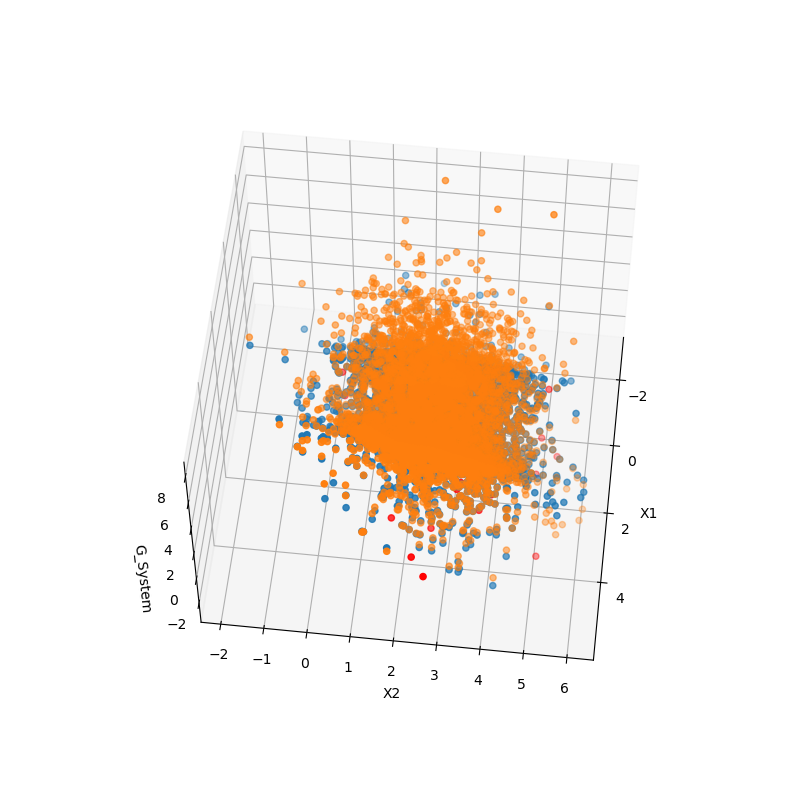

Text(0.5, 0, 'G_System')

In [27]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XR[:,0],XR[:,1], YN_1)
ax.scatter(XR[:,0],XR[:,1], mean_1)             #plotting surrogate
ax.scatter(xr[:,0],xr[:,1], yn_1, color='red')   #observation points 1

# ax.scatter(XR[:,0],XR[:,1], YN_2)
# ax.scatter(XR[:,0],XR[:,1], mean_2)             #plotting surrogate
# ax.scatter(xr[:,0],xr[:,1], yn_2, color='red')   #observation points 1

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('G_System')

In [ ]:
%matplotlib notebook

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(XR[:,0],XR[:,1], YN_1)
ax.scatter(XR[:,0],XR[:,1], mean0)             #plotting the last trained surrogate
ax.scatter(xr[:,0],xr[:,1], yn_1, color='red')   #observation points 
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('G_System')

In [ ]:
#load model
filename = 'testLOO_AT_U_LS1.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
loaded_model['10points']

# "Manual" active training

In [ ]:
#TRAIN MODEL 
# kernel hyperparameters------------------------------
v = 5/2
#n = 11 
#truncation term-------------------------------------
p_max = 4  #for each variable → same truncation , degree of expansion
mse_results = np.zeros(p_max-1)
opt_length_it = np.zeros(p_max-1)

dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])

for p in range(1, p_max):
    results = dict()
    bounds = [(lmin, lmax)]
    results['shgo'] = optimize.shgo(L_Object, bounds)
    opt_length = results['shgo']['x'][0]
    
    theta = np.array([opt_length, v])

    modelpar1 = PCK1.train (xn, yn, p, theta) 
    mean0, var0 = PCK1.predict_fast(XN)    # mean, variance
    
    mse = np.mean ((YN - mean0)**2)
    mse_results[p-1] = mse
    opt_length_it[p-1] = opt_length
    print('Degree', p, 'MSE', "%.2f" % round(mse, 2))
    
opt = np.argmin(mse_results) 
modelpar1 = PCK1.train (xn, yn, int(opt+1), np.array([opt_length_it[opt], v])) 

MCS and evaluating U function

In [ ]:
MCS_samples = 100000

MCinputs_norm = np.zeros((int(MCS_samples), dim))
MCinputs = np.zeros((int(MCS_samples), dim))

MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  

# ---------------------------------------------------
ymc = function(MCinputs)[0]  
fail_samples = np.sum(ymc < 0 )
Pf_ref = fail_samples/MCS_samples

meanMC, varMC = PCK1.predict_fast(MCinputs_norm)    # mean, variance
fail_samples_SUMO = np.sum(np.asarray(meanMC) < 0 )
fail_prob_SUMO = fail_samples_SUMO / MCS_samples

print(Pf_ref, fail_prob_SUMO)

### Evaluating U function and adding training point

In [ ]:
U_f = U_function(meanMC.reshape(-1), varMC.reshape(-1))
#np.argmax(U_f)
#MCinputs_norm[np.argmin(U_f)]
## Add fancy plot
plt.plot(U_f)
ax.set_yscale('log')
#plt.plot(varMC)

xr = np.append(xr, MCinputs[np.argmin(U_f)]).reshape(-1,2)
xn = np.append(xn, MCinputs_norm[np.argmin(U_f)]).reshape(-1,2)

yn = function(xr)[0] #Only one point needs to be evaluated here

print('number of training points: ', len(xn))

## Newly created functions

In [ ]:
def predict_pm (XN):
        ff0 = time.time()
        Rn = PCK1.matern(PCK1.doe, PCK1.doe, PCK1.hyperp[0], PCK1.hyperp[1])
        ff1 = time.time()
        Rn_inv = np.linalg.inv(Rn)
        ff2 = time.time()
        
        size_XN = XN.shape
        mean_predict = np.zeros(size_XN[0])
        var_predict = np.zeros(size_XN[0])
    
        for i in range(size_XN[0]):
            ff22 = time.time()
            fx = PCK1.info_matrix(XN[i].reshape(1,2), PCK1.Poly_ind)
            ff3 = time.time()
            rx = matern_pm(XN[i].reshape(1,2), PCK1.doe, PCK1.hyperp[0], PCK1.hyperp[1])
            ff4 = time.time()
            
            mean1 = fx @ PCK1.coeff
            #ff5 = time.time()
            mean2 = rx @ Rn_inv @ (PCK1.observ - (PCK1.InfoMat @ PCK1.coeff))
            #ff6 = time.time()
            mean_total = mean1 + mean2
            #ff7 = time.time()
                
            ux = ( PCK1.InfoMat.T @ Rn_inv @ rx.T) - fx.T
            #ff8 = time.time()
            term1 = rx @ Rn_inv @ rx.T
            #ff9 = time.time()
            term2 = ux.T @ np.linalg.inv(PCK1.InfoMat.T @ Rn_inv @ PCK1.InfoMat) @ ux
            #ff10 = time.time()
            variance = PCK1.sigmaSQ * ( 1 - term1 + term2)
            #ff11 = time.time()
        
            mean_predict[i] = mean_total
            var_predict[i] = variance[0]
        
        print(ff1 - ff0)
        print(ff2 - ff1)
        print(ff3*10000 - ff22*10000, 'EE')
        print(ff4*10000 - ff3*10000, 'HH')
        #print(ff5*10000 - ff4*10000)
        #print(ff6*10000 - ff5*10000)
        #print(ff7*10000 - ff6*10000)
        #print(ff8*10000 - ff7*10000)
        #print(ff9*10000 - ff8*10000)
        #print(ff10*10000 - ff9*10000)
        #print(ff11*10000 - ff10*10000)
        
        return mean_predict , var_predict

In [ ]:
import math
def matern_pm(xr, xn, l, v):     
    #l, hyperparameter (length scaled)
        #matern parameter, v can be 3/2, 5/2
    
    size_xn = xn.shape
    d = np.linalg.norm(xr - xn, axis=1).reshape(1, size_xn[0])
      
    if v == 3/2:
        R = (1+ np.sqrt(3)*d/l) * np.exp(-(np.sqrt(3)*d/l))
    elif v == 5/2:
        R = ((1+ (np.sqrt(5)*d/l) + (5/3)*(d/l)**2 )* np.exp(-(np.sqrt(5)*d/l)))
        
    return R

def distance_pm(x, xk):                        #multidimensional distance between 2 samples
    d = np.zeros((len(x),len(xk)))
        
    for j in range(0,len(xk)):
        for i in range(0,len(x)):
            d[i,j] = d[i,j] + np.sqrt(np.sum((x[i]-xk[j])**2))
    return d

## Former cells

In [ ]:
#definition of input parameters----------------------------------------------

# seed=0      # fixing seed random number generator
# np.random.seed(seed)         #fixing seed random number generator

function = gfun_53   #choose the ground truth function

dim = 2       # dimensionality
n = 30       # number of initial sampling
ntest = 5000  # test points

#------------------------------------------------------------
xn = np.zeros((int(n), dim))      #normalized training points
xr = np.zeros((int(n), dim))      #scaled training points
yn = np.zeros((int(n)))           #observations
#------------------------------------------------------------

#initial design of experiments (LHS) --------------------------------
x1mean, x1sigma = 1.5 , 1.0  # normal distribution 
x2mean, x2sigma = 2.5 , 1.0  # normal distribution 

# Check the variables limits for space-filling distribution (NORMAL DISTRIBUTIONS???)
Xdoe = build.space_filling_lhs( {'x1':[-1, 1],      
                                 'x2':[-1, 1],} , 
                                  num_samples = n )
#------------------------------------------------------------
xn[:,0] = Xdoe['x1']
xn[:,1] = Xdoe['x2']
xr[:,0] = PCK1.scalehermite(xn[:,0], x1mean, x1sigma)
xr[:,1] = PCK1.scalehermite(xn[:,1], x2mean, x2sigma)

# TEST POINTS -------------------------------------------------
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
YN = np.zeros(int(ntest)) 
#variable 1 ---------------------------------------------------
XN[:,0] = np.random.normal(0,1,ntest)  
XR[:,0] = PCK1.scalehermite(XN[:,0], x1mean, x1sigma)  
#variable 2 ---------------------------------------------------
XN[:,1] = np.random.normal(0,1,ntest)  
XR[:,1] = PCK1.scalehermite(XN[:,1], x2mean, x2sigma)  

yn = function(xr)[0]
YN = function(XR)[0]

In [ ]:
YN

In [ ]:
#TRAIN MODEL 
# kernel hyperparameters------------------------------
l = 1.00   #length scale
v = 5/2
theta = np.array([l,v])

#truncation term-------------------------------------
p = 2  #for each variable → same truncation , degree of expansion

modelpar1= PCK1.train (xn,yn,p,theta)    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
modelpar1[0], modelpar1[1]   ## B, sig2,

In [ ]:
import time
# model predictions -----------------------------------------

ntest = 100000  # test points
seed = 0      # fixing seed random number generator
np.random.seed(seed)         #fixing seed random number generator

# test points -------------------------------------------------
XR = np.zeros((int(ntest), dim))   #normalized test points
XN = np.zeros((int(ntest), dim))  #scaled test points
YN = np.zeros(int(ntest)) 
#variable 1 ---------------------------------------------------
XN[:,0] = np.random.normal(0,1,ntest)  
XR[:,0] = PCK1.scalehermite(XN[:,0], x1mean, x1sigma)  
#variable 2 ---------------------------------------------------
XN[:,1] = np.random.normal(0,1,ntest)  
XR[:,1] = PCK1.scalehermite(XN[:,1], x2mean, x2sigma)  

G_VAL_SYS = function(XR)
YN = G_VAL_SYS[0]

#a0 = time.time()
#mean1, var1 = PCK1.predict(XN)
a1 = time.time()

mean2, var2 = PCK1.predict_fast(XN)
a2 = time.time()

#mse = np.mean ((YN - mean1)**2)
#print(mse)
print(mean2, var2)
print(a2-a1)

In [ ]:
# Polynomial with the smallest MSE for the given DOE --------------------------------------
v= 5/2       #matern coefficient
PCK0 = PC_Kriging(config)

#selecting length scale ------------
dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])
l= results['shgo']['x']
    
if (l < lmin and l > lmax ):
    l = lmin
    
maxpoly = 10

for j in range (1,maxpoly): 
    # MODEL TRAINING
    modelpar0 = PCK0.train (xn,yn,j,theta)    # returns B, sig2

    # MODEL PREDICTIONS
    mean0,var0 = PCK0.predict(XN)    # mean, variance
    
    # generalization error  ---------------------------------------------
    mse = np.mean ((YN - mean0)**2)
    
    print('Degree', j, 'MSE', "%.2f" % round(mse, 2))

In [ ]:
# Polynomial with the smallest MSE for the given DOE --------------------------------------
v= 5/2       #matern coefficient
PCK0 = PC_Kriging(config)

#selecting length scale ------------
dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])

In [ ]:
# objective function to optimize length scale --------------------------------------------------------
def L_Object (l):
    v = 5/2
    N = len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)
    
    modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
    ### ------------------Theta_ by UQLab User Manual PCK(C. Lataniotis, D. Wicaksono, S. Marelli, B. Sudret)------------------------------
    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = PCK1.InfoMat @ modelpar2[0]
    ins = (yn-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))

In [ ]:
# objective function to optimize length scale --------------------------------------------------------
def L_Object (l):
    v=5/2
    N=len(xn)
    R = PCK1.matern(xn , xn, l, v)
    detR = np.linalg.det(R)
    
    modelpar2 = PCK1.train(xn, yn, p, np.array([l,v]))    # returns B, sig2, InfoMatrix(phi) , PolyIndices(alpha)
    ### ------------------Theta_ by UQLab User Manual PCK(C. Lataniotis, D. Wicaksono, S. Marelli, B. Sudret)------------------------------
    sig2 = modelpar2[1].reshape(-1)
    # return 0.5*(np.log(detR)+ N*np.log(2*np.pi*sig2)+ N)

    ### ------------------Theta_ by MLE PCK(Schobi,Sudret,Wiart)------------------------------
    FB = PCK1.InfoMat @ modelpar2[0]
    ins = (yn-FB).reshape(-1)
    R_1 = np.linalg.inv(R)
    return ((ins.T) @ R_1 @ ins) * (1/N) * (detR**(1/N))
    
results = dict()
bounds = [(lmin, lmax)]

results['shgo'] = optimize.shgo(L_Object, bounds)   #bounds must be a list [lmin, lmax]
results['DA'] = optimize.dual_annealing(L_Object, bounds)
results['DE'] = optimize.differential_evolution(L_Object, bounds)

bounds, results['shgo']['x'], results['DA']['x'],results['DE']['x']

In [ ]:
# Polynomial with the smallest MSE for the given DOE --------------------------------------
v= 5/2       #matern coefficient
PCK0 = PC_Kriging(config)

#selecting length scale ------------
dist = PCK1.distance(xr, xr)
lmax = np.max(dist)
lmin = np.min(dist[dist!=0])
l= results['shgo']['x']
    
if (l < lmin and l > lmax ):
    l = lmin
    
maxpoly = 10

for j in range (1,maxpoly): 
    # MODEL TRAINING
    modelpar0 = PCK0.train (xn,yn,j,theta)    # returns B, sig2

    # MODEL PREDICTIONS
    mean0,var0 = PCK0.predict(XN)    # mean, variance
    
    # generalization error  ---------------------------------------------
    mse = np.mean ((YN - mean0)**2)
    
    print('Degree', j, 'MSE', "%.2f" % round(mse, 2))

In [ ]:
#################################################################
# FIXED VALUES --------------------------------------
# v= 5/2       #matern coefficient
p = 2        #truncation term
z = 0        #target value 

# MCS ------------------------------------------------

MCS_samples = 100

MCinputs_norm = np.zeros((int(MCS_samples), dim))
MCinputs = np.zeros((int(MCS_samples), dim))

MCinputs_norm[:,0] = np.random.normal(0, 1, size=int(MCS_samples))
MCinputs_norm[:,1] = np.random.normal(0, 1, size=int(MCS_samples))

MCinputs[:,0] = PCK1.scalehermite(MCinputs_norm[:,0], x1mean, x1sigma)  
MCinputs[:,1] = PCK1.scalehermite(MCinputs_norm[:,1], x2mean, x2sigma)  

# ---------------------------------------------------
ymc = function(MCinputs)[0]  
fail_samples = np.sum(ymc < 0 )
Pf_ref = fail_samples/MCS_samples

#################################################################
# LOOP ----------------------------------------------------------
budget = 10

Pf_SUMO = []
eff1 = np.zeros(ntest)

for j in range (1,budget): 

    # UPDATE n, xn, xr, yn
    
    n=len(xn)
    LOOCV = np.zeros(ntest)
    mean_loo = np.zeros(n)
    var_loo = np.zeros(n)

    #model evaluations -----------------
    yn = function(xr)[0]

    #selecting length scale ------------
    results = dict()
    
    dist = PCK1.distance(xn, xn)
    lmax = np.max(dist)
    lmin = np.min(dist[dist!=0])
    bounds = [(lmin, lmax)]
    
    results['shgo'] = optimize.shgo(L_Object, bounds)
    l= results['shgo']['x']
    
    if (l < lmin and l > lmax ):
        l = lmin
    
    print(l, lmin, lmax)
#     l = np.min(dist[dist!=0])     #assigning the minimum distance between two points

    theta = np.array([l,v])

    # MODEL TRAINING
    modelpar1 = PCK1.train (xn,yn,p,theta)    # returns B, sig2

    # MODEL PREDICTIONS
    mean1,var1 = PCK1.predict(XN)    # mean, variance

    # LOO CV errors ###################################################
    #Generating PCK models for each reduced design of experiments 

#     for i in range (0,n):             
#         yn_loo=  np.delete(yn,[i])                              #y_n-i      leaving element i out the observations 
#         xr_loo= np.delete(xr,[i*2,i*2+1]).reshape(-1,dim)      #x1r_n-i   leaving element i out the inputs (xr)
#         xn_loo= np.delete(xn,[i*2,i*2+1]).reshape(-1,dim)      #x_n-i     leaving element i out the nomalized inputs (xn)

#         #training LOO
#         modelpar_loo = PCK_loo.train (xn_loo,yn_loo,p,theta)   # same (p) as specified in the original model

#         #predicting LOO
#         mean_loo[i], var_loo[i] = PCK_loo.predict(xn[i].reshape(1,-1))



#     e_loo = (yn - mean_loo)**2              #LOO CV squared errors
#     sumat = np.divide(e_loo,var_loo)        #vector (e_loo / s_loo) for each observed point


#     for k in range (0,ntest):               #variance enhancement based LOO CV erros around voronoi cells
#         voro = VoronoiCell(XR[k],xr)

#         LOOCV[k]= var_plot[k]*(1+sumat[voro])   
    ####################################################
    #Pf estimation ------------------------------------------
    #surrogate pred -----------------------------------------
    mean_MCS = []
    
    # var_MCS = []

    for m in range (0, int(MCS_samples)):
        mean_,var_ = PCK1.predict(MCinputs_norm[m].reshape(1,-1))
        mean_MCS.append(mean_.tolist())
    #     var_MCS.append(var_.tolist())

    fail_samples_SUMO = np.sum(np.asarray(mean_MCS) < 0 )
    fail_prob_SUMO = fail_samples_SUMO / MCS_samples
    Pf_SUMO.append(fail_prob_SUMO.tolist())
    #################################################### 
    
    #-------------------------------------- EFF
#     eff1 = EFF(np.squeeze(mean1),LOOCV,z)    #with LOO cv

    eff1 = EFF(np.squeeze(mean1),var1,z)

    maxEff = np.argmax(eff1)
    Xr_new = XR[maxEff]
    Xn_new = XN[maxEff]
    
    #-------------------------------------- U_function
# #     U_f = U_function(mean1.reshape(-1), LOOCV.reshape(-1))    #with LOO cv
#     U_f = U_function(mean1.reshape(-1), var1.reshape(-1))
    
#     minU = np.argmin(U_f)
#     Xr_new = XR[minU]   

    # adding observation and updating -----------------------------------
    xr = np.append(xr,Xr_new).reshape(-1,2)
    xn = np.append(xn,Xn_new).reshape(-1,2)
    
    # generalization error  ---------------------------------------------
    mse = np.mean ((YN - mean1)**2)
    ####################################################
    #Pf estimation ------------------------------------------
    #surrogate pred -----------------------------------------
    mean_MCS = []

    for m in range (0, int(MCS_samples)):
        mean_,var_ = PCK1.predict(MCinputs_norm[m].reshape(1,-1))
        mean_MCS.append(mean_.tolist())

    fail_samples_SUMO = np.sum(np.asarray(mean_MCS) < 0 )
    fail_prob_SUMO = fail_samples_SUMO / MCS_samples
    Pf_SUMO.append(fail_prob_SUMO.tolist())
    
    pf_error = np.abs( (Pf_ref - fail_prob_SUMO)) / Pf_ref 
    ####################################################
    print(j, 'Pf ', "%.4f" % round(fail_prob_SUMO, 4) , 'pf_error', "%.2f" % round(pf_error, 2) )
    
yn = function(xr)[0]